In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#Load the modules
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc #garbage collection, we need to save all the RAM we can
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
#

# Any results you write to the current directory are saved as output.

Load the labels and filenames

In [12]:
#set paths to training and test data
path = "../input/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(3) # print the first three entrys

,path,id,label
0,../input/train/53cd84dd8190c3b61869e5c6e364ef7...,53cd84dd8190c3b61869e5c6e364ef71618d0803,0
1,../input/train/1fd38079166dec3f0b2d10111c1326b...,1fd38079166dec3f0b2d10111c1326beaa71ab7b,0
2,../input/train/698888e4039fcc82bec0414a5a1c452...,698888e4039fcc82bec0414a5a1c452673a075de,0


Load the images

In [13]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [14]:
# Load 10k images
N=10000
X,y = load_data(N=N,df=df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Exploratory Data Analysis (EDA)  
1. 看一下图片
2. 了解两种类别的分布情况
3. 看一下特征

some example images

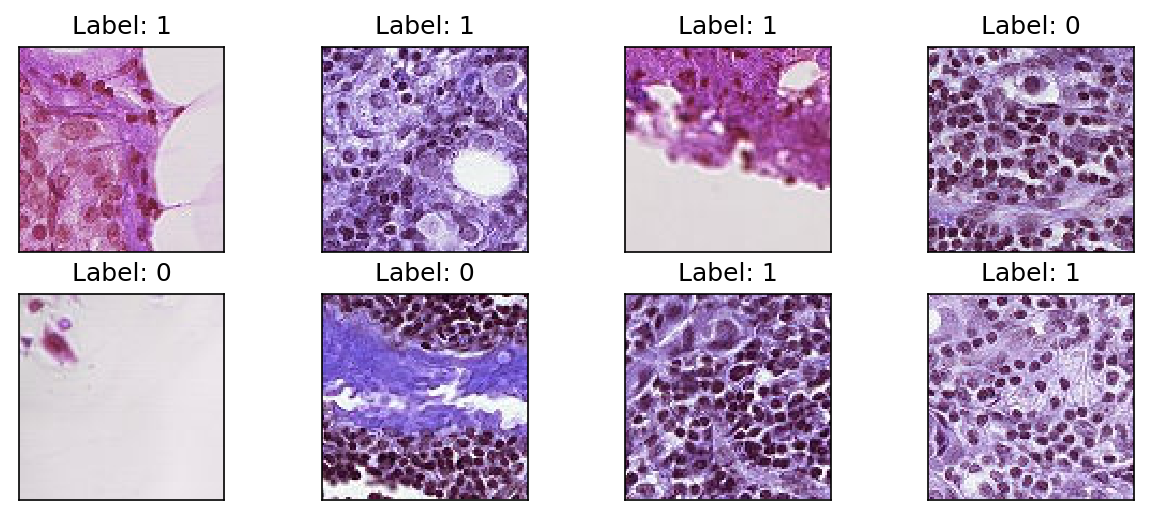

In [15]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

the data distribution

Text(0, 0.5, '# of samples')

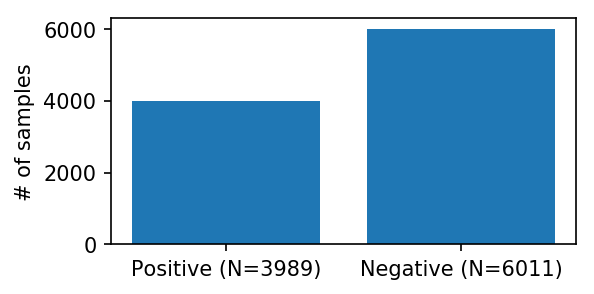

In [16]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

过采样和欠采样可以避免分类器中的偏差并改善训练期间的稳定性

In [17]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

compare the distribution of pixel values for each color channel (RGB) individually and all channels together

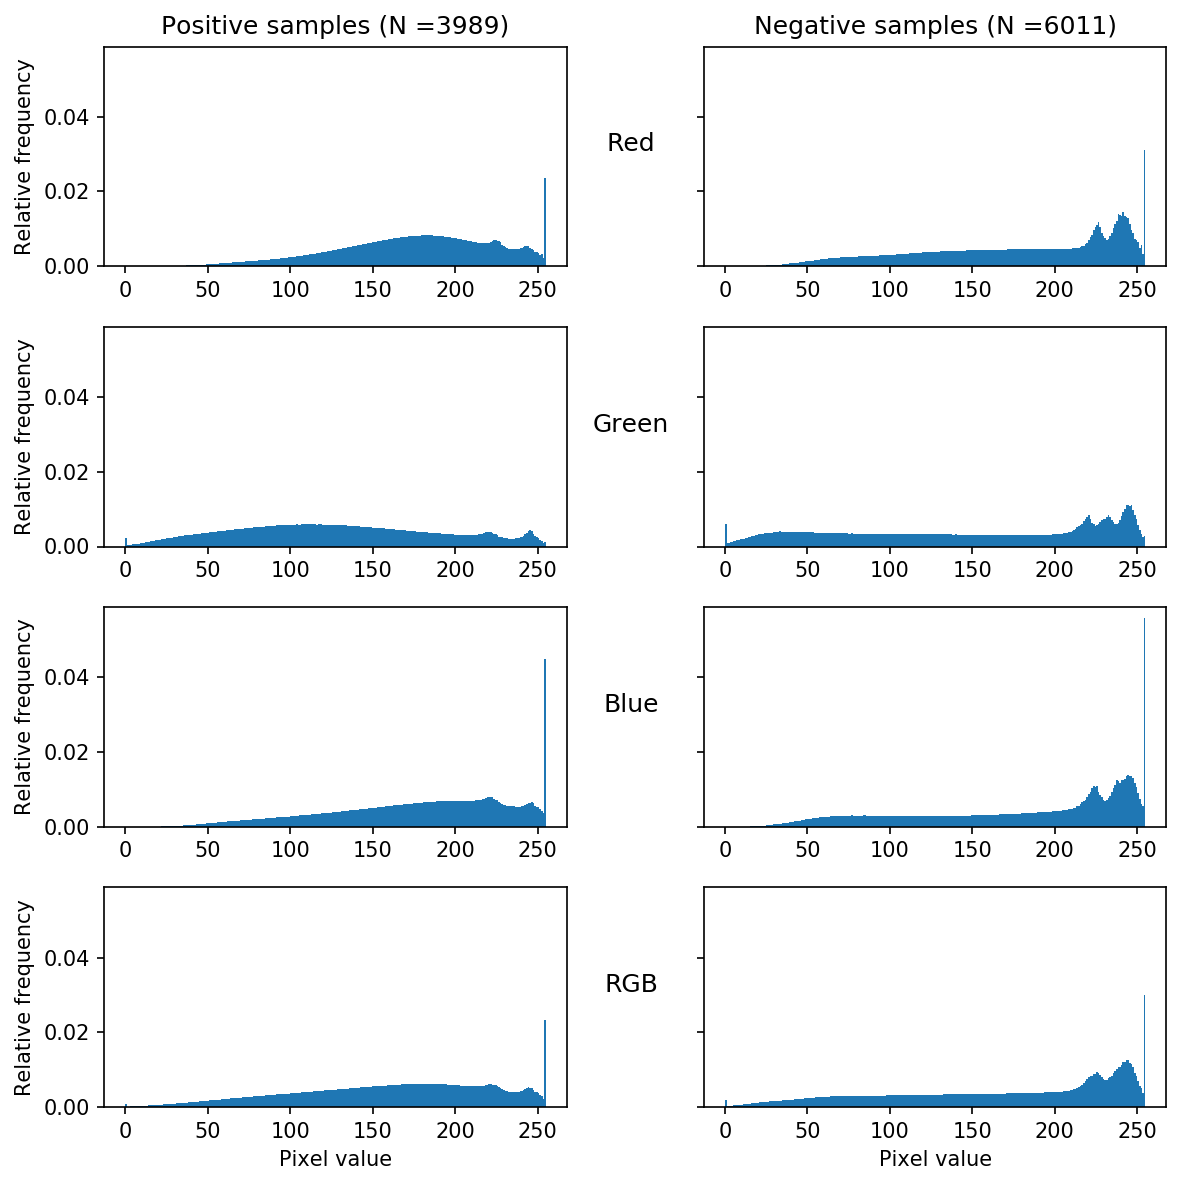

In [18]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

1. 与正样本相比，负样本像素更多在高亮度部分，特别是在绿通道中  
2. 正样本中，相比于其他两通道，绿通道中的像素更暗。而负样本不是这样
3. 正负样本中都存在大部分亮白色区域

take the mean of each individual image and look at that distribution.

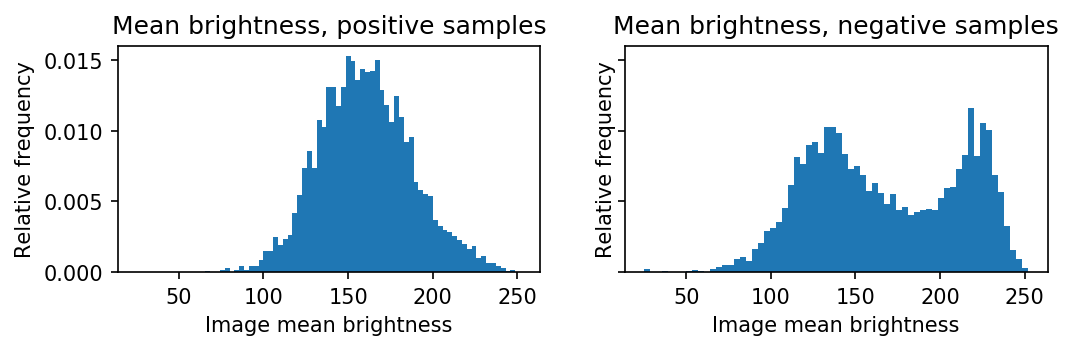

In [19]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

1. 正样本的平均亮度分布接近于均值为150正态分布
2. 负样本近似双峰分布，峰值为140和225

通过EDA，我们可以得到以下结论
1. 正负样本在像素的分布和平均亮度的分布上有明显的区别，我们的模型可以利用这一点
2. 一些图片包含了很亮的区域，可能是记录过程中的人为因素导致，我们需要找到一种方法解决他们。他们在正负样本中都有，所以不能当作一个特征
3. 负样本多于正样本很多，可能需要调整

loading all the data

In [20]:
#N = df["path"].size # get the number of images in the training data set
N=10000
X,y = load_data(N=N,df=df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


free up space in our RAM

In [21]:
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

split the data into a training and validation set

In [22]:
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

neural network architecture

In [23]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, dilation_rate = (2,2), input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, dilation_rate = (2,2), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, dilation_rate = (2,2), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, dilation_rate = (2,2), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, dilation_rate = (2,2), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, dilation_rate = (2,2), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

Train and validate the model

In [25]:
def printplot(time,accurate1,accurate2):
    i=os.system("cls")
    plt.plot(range(time), accurate1, mec='r', mfc='w',label=u'training')
    plt.plot(range(time), accurate2, mec='g', mfc='w',label=u'validation')
    plt.legend()  # 让图例生效
    plt.xlabel("time(s)") #X轴标签
    plt.ylabel("accuracy") #Y轴标签
    plt.title("CNN 10000") #标题

    plt.show()

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 2s 875us/step


  1%|          | 1/160 [00:06<17:06,  6.46s/it]

1999/1999 [==============================] - 1s 349us/step


  1%|▏         | 2/160 [00:07<12:29,  4.74s/it]

1999/1999 [==============================] - 1s 354us/step


  2%|▏         | 3/160 [00:07<09:16,  3.55s/it]

1999/1999 [==============================] - 1s 355us/step


  2%|▎         | 4/160 [00:08<07:02,  2.71s/it]

1999/1999 [==============================] - 1s 350us/step


  3%|▎         | 5/160 [00:09<05:28,  2.12s/it]

1999/1999 [==============================] - 1s 352us/step


  4%|▍         | 6/160 [00:10<04:23,  1.71s/it]

1999/1999 [==============================] - 1s 350us/step


  4%|▍         | 7/160 [00:10<03:37,  1.42s/it]

1999/1999 [==============================] - 1s 351us/step


  5%|▌         | 8/160 [00:11<03:05,  1.22s/it]

1999/1999 [==============================] - 1s 353us/step


  6%|▌         | 9/160 [00:12<02:42,  1.08s/it]

1999/1999 [==============================] - 1s 353us/step


  6%|▋         | 10/160 [00:13<02:27,  1.02it/s]

1999/1999 [==============================] - 1s 352us/step


  7%|▋         | 11/160 [00:13<02:15,  1.10it/s]

1999/1999 [==============================] - 1s 355us/step


  8%|▊         | 12/160 [00:14<02:08,  1.15it/s]

1999/1999 [==============================] - 1s 353us/step


  8%|▊         | 13/160 [00:15<02:02,  1.20it/s]

1999/1999 [==============================] - 1s 352us/step


  9%|▉         | 14/160 [00:16<01:57,  1.24it/s]

1999/1999 [==============================] - 1s 353us/step


  9%|▉         | 15/160 [00:16<01:54,  1.26it/s]

1999/1999 [==============================] - 1s 354us/step


 10%|█         | 16/160 [00:17<01:52,  1.28it/s]

1999/1999 [==============================] - 1s 352us/step


 11%|█         | 17/160 [00:18<01:50,  1.30it/s]

1999/1999 [==============================] - 1s 353us/step


 11%|█▏        | 18/160 [00:19<01:48,  1.31it/s]

1999/1999 [==============================] - 1s 351us/step


 12%|█▏        | 19/160 [00:19<01:47,  1.32it/s]

1999/1999 [==============================] - 1s 353us/step


 12%|█▎        | 20/160 [00:20<01:46,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 13%|█▎        | 21/160 [00:21<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 14%|█▍        | 22/160 [00:22<01:43,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 14%|█▍        | 23/160 [00:22<01:42,  1.33it/s]

1999/1999 [==============================] - 1s 363us/step


 15%|█▌        | 24/160 [00:23<01:43,  1.32it/s]

1999/1999 [==============================] - 1s 352us/step


 16%|█▌        | 25/160 [00:24<01:41,  1.32it/s]

1999/1999 [==============================] - 1s 353us/step


 16%|█▋        | 26/160 [00:25<01:41,  1.33it/s]

1999/1999 [==============================] - 1s 356us/step


 17%|█▋        | 27/160 [00:26<01:40,  1.32it/s]

1999/1999 [==============================] - 1s 355us/step


 18%|█▊        | 28/160 [00:26<01:39,  1.32it/s]

1999/1999 [==============================] - 1s 355us/step


 18%|█▊        | 29/160 [00:27<01:38,  1.32it/s]

1999/1999 [==============================] - 1s 354us/step


 19%|█▉        | 30/160 [00:28<01:38,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 19%|█▉        | 31/160 [00:29<01:37,  1.33it/s]

1999/1999 [==============================] - 1s 358us/step


 20%|██        | 32/160 [00:29<01:36,  1.32it/s]

1999/1999 [==============================] - 1s 353us/step


 21%|██        | 33/160 [00:30<01:35,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 21%|██▏       | 34/160 [00:31<01:35,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 22%|██▏       | 35/160 [00:32<01:34,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 22%|██▎       | 36/160 [00:32<01:33,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 23%|██▎       | 37/160 [00:33<01:32,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 24%|██▍       | 38/160 [00:34<01:31,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 24%|██▍       | 39/160 [00:35<01:30,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 25%|██▌       | 40/160 [00:35<01:30,  1.33it/s]

1999/1999 [==============================] - 1s 356us/step


 26%|██▌       | 41/160 [00:36<01:29,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 26%|██▋       | 42/160 [00:37<01:28,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 27%|██▋       | 43/160 [00:38<01:27,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 28%|██▊       | 44/160 [00:38<01:27,  1.32it/s]

1999/1999 [==============================] - 1s 366us/step


 28%|██▊       | 45/160 [00:39<01:27,  1.31it/s]

1999/1999 [==============================] - 1s 363us/step


 29%|██▉       | 46/160 [00:40<01:27,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 29%|██▉       | 47/160 [00:41<01:26,  1.30it/s]

1999/1999 [==============================] - 1s 365us/step


 30%|███       | 48/160 [00:41<01:26,  1.30it/s]

1999/1999 [==============================] - 1s 367us/step


 31%|███       | 49/160 [00:42<01:25,  1.29it/s]

1999/1999 [==============================] - 1s 366us/step


 31%|███▏      | 50/160 [00:43<01:25,  1.29it/s]

1999/1999 [==============================] - 1s 361us/step


 32%|███▏      | 51/160 [00:44<01:24,  1.29it/s]

1999/1999 [==============================] - 1s 361us/step


 32%|███▎      | 52/160 [00:45<01:23,  1.29it/s]

1999/1999 [==============================] - 1s 364us/step


 33%|███▎      | 53/160 [00:45<01:22,  1.29it/s]

1999/1999 [==============================] - 1s 366us/step


 34%|███▍      | 54/160 [00:46<01:22,  1.29it/s]

1999/1999 [==============================] - 1s 361us/step


 34%|███▍      | 55/160 [00:47<01:21,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


 35%|███▌      | 56/160 [00:48<01:20,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


 36%|███▌      | 57/160 [00:48<01:19,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


 36%|███▋      | 58/160 [00:49<01:18,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


 37%|███▋      | 59/160 [00:50<01:17,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 38%|███▊      | 60/160 [00:51<01:16,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


 38%|███▊      | 61/160 [00:51<01:16,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


 39%|███▉      | 62/160 [00:52<01:15,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 39%|███▉      | 63/160 [00:53<01:14,  1.30it/s]

1999/1999 [==============================] - 1s 353us/step


 40%|████      | 64/160 [00:54<01:13,  1.31it/s]

1999/1999 [==============================] - 1s 353us/step


 41%|████      | 65/160 [00:54<01:12,  1.32it/s]

1999/1999 [==============================] - 1s 352us/step


 41%|████▏     | 66/160 [00:55<01:11,  1.32it/s]

1999/1999 [==============================] - 1s 356us/step


 42%|████▏     | 67/160 [00:56<01:10,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


 42%|████▎     | 68/160 [00:57<01:09,  1.33it/s]

1999/1999 [==============================] - 1s 357us/step


 43%|████▎     | 69/160 [00:57<01:08,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 44%|████▍     | 70/160 [00:58<01:07,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 44%|████▍     | 71/160 [00:59<01:07,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 45%|████▌     | 72/160 [01:00<01:06,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 46%|████▌     | 73/160 [01:00<01:05,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 46%|████▋     | 74/160 [01:01<01:04,  1.33it/s]

1999/1999 [==============================] - 1s 355us/step


 47%|████▋     | 75/160 [01:02<01:03,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 48%|████▊     | 76/160 [01:03<01:03,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 77/160 [01:03<01:02,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 49%|████▉     | 78/160 [01:04<01:01,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 49%|████▉     | 79/160 [01:05<01:00,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 50%|█████     | 80/160 [01:06<00:59,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 51%|█████     | 81/160 [01:06<00:59,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 51%|█████▏    | 82/160 [01:07<00:58,  1.33it/s]

1999/1999 [==============================] - 1s 355us/step


 52%|█████▏    | 83/160 [01:08<00:57,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 52%|█████▎    | 84/160 [01:09<00:57,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 53%|█████▎    | 85/160 [01:09<00:56,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 54%|█████▍    | 86/160 [01:10<00:55,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 54%|█████▍    | 87/160 [01:11<00:54,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 55%|█████▌    | 88/160 [01:12<00:54,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 56%|█████▌    | 89/160 [01:12<00:53,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 56%|█████▋    | 90/160 [01:13<00:52,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 57%|█████▋    | 91/160 [01:14<00:51,  1.33it/s]

1999/1999 [==============================] - 1s 357us/step


 57%|█████▊    | 92/160 [01:15<00:51,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 58%|█████▊    | 93/160 [01:16<00:50,  1.33it/s]

1999/1999 [==============================] - 1s 356us/step


 59%|█████▉    | 94/160 [01:16<00:49,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 59%|█████▉    | 95/160 [01:17<00:48,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 60%|██████    | 96/160 [01:18<00:48,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 61%|██████    | 97/160 [01:19<00:47,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 61%|██████▏   | 98/160 [01:19<00:46,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 62%|██████▏   | 99/160 [01:20<00:45,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 62%|██████▎   | 100/160 [01:21<00:44,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 63%|██████▎   | 101/160 [01:22<00:44,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 64%|██████▍   | 102/160 [01:22<00:43,  1.33it/s]

1999/1999 [==============================] - 1s 361us/step


 64%|██████▍   | 103/160 [01:23<00:43,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 65%|██████▌   | 104/160 [01:24<00:42,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 66%|██████▌   | 105/160 [01:25<00:41,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 66%|██████▋   | 106/160 [01:25<00:40,  1.33it/s]

1999/1999 [==============================] - 1s 363us/step


 67%|██████▋   | 107/160 [01:26<00:40,  1.32it/s]

1999/1999 [==============================] - 1s 353us/step


 68%|██████▊   | 108/160 [01:27<00:39,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 68%|██████▊   | 109/160 [01:28<00:38,  1.32it/s]

1999/1999 [==============================] - 1s 357us/step


 69%|██████▉   | 110/160 [01:28<00:37,  1.32it/s]

1999/1999 [==============================] - 1s 355us/step


 69%|██████▉   | 111/160 [01:29<00:37,  1.32it/s]

1999/1999 [==============================] - 1s 361us/step


 70%|███████   | 112/160 [01:30<00:36,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


 71%|███████   | 113/160 [01:31<00:35,  1.32it/s]

1999/1999 [==============================] - 1s 353us/step


 71%|███████▏  | 114/160 [01:31<00:34,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 72%|███████▏  | 115/160 [01:32<00:33,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 72%|███████▎  | 116/160 [01:33<00:33,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 73%|███████▎  | 117/160 [01:34<00:32,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 74%|███████▍  | 118/160 [01:34<00:31,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 74%|███████▍  | 119/160 [01:35<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 355us/step


 75%|███████▌  | 120/160 [01:36<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 76%|███████▌  | 121/160 [01:37<00:29,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 76%|███████▋  | 122/160 [01:37<00:28,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 77%|███████▋  | 123/160 [01:38<00:27,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 78%|███████▊  | 124/160 [01:39<00:27,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 78%|███████▊  | 125/160 [01:40<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 357us/step


 79%|███████▉  | 126/160 [01:40<00:25,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 79%|███████▉  | 127/160 [01:41<00:24,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 80%|████████  | 128/160 [01:42<00:24,  1.33it/s]

1999/1999 [==============================] - 1s 356us/step


 81%|████████  | 129/160 [01:43<00:23,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 81%|████████▏ | 130/160 [01:43<00:22,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 82%|████████▏ | 131/160 [01:44<00:21,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 82%|████████▎ | 132/160 [01:45<00:21,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 83%|████████▎ | 133/160 [01:46<00:20,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 84%|████████▍ | 134/160 [01:46<00:19,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 84%|████████▍ | 135/160 [01:47<00:18,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 85%|████████▌ | 136/160 [01:48<00:18,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 86%|████████▌ | 137/160 [01:49<00:17,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 86%|████████▋ | 138/160 [01:49<00:16,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 87%|████████▋ | 139/160 [01:50<00:15,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 88%|████████▊ | 140/160 [01:51<00:15,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 88%|████████▊ | 141/160 [01:52<00:14,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 89%|████████▉ | 142/160 [01:52<00:13,  1.33it/s]

1999/1999 [==============================] - 1s 357us/step


 89%|████████▉ | 143/160 [01:53<00:12,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 90%|█████████ | 144/160 [01:54<00:12,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 91%|█████████ | 145/160 [01:55<00:11,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 91%|█████████▏| 146/160 [01:55<00:10,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 92%|█████████▏| 147/160 [01:56<00:09,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 92%|█████████▎| 148/160 [01:57<00:08,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 93%|█████████▎| 149/160 [01:58<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 94%|█████████▍| 150/160 [01:58<00:07,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 94%|█████████▍| 151/160 [01:59<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 95%|█████████▌| 152/160 [02:00<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 96%|█████████▌| 153/160 [02:01<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 96%|█████████▋| 154/160 [02:01<00:04,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 97%|█████████▋| 155/160 [02:02<00:03,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 98%|█████████▊| 156/160 [02:03<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 358us/step


 98%|█████████▊| 157/160 [02:04<00:02,  1.33it/s]

1999/1999 [==============================] - 1s 365us/step


 99%|█████████▉| 158/160 [02:04<00:01,  1.32it/s]

1999/1999 [==============================] - 1s 362us/step


 99%|█████████▉| 159/160 [02:05<00:00,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


100%|██████████| 160/160 [02:06<00:00,  1.31it/s]


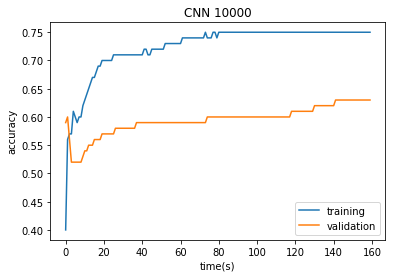

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 365us/step


  1%|          | 1/160 [00:00<02:04,  1.27it/s]

1999/1999 [==============================] - 1s 362us/step


  1%|▏         | 2/160 [00:01<02:03,  1.28it/s]

1999/1999 [==============================] - 1s 360us/step


  2%|▏         | 3/160 [00:02<02:02,  1.29it/s]

1999/1999 [==============================] - 1s 359us/step


  2%|▎         | 4/160 [00:03<02:00,  1.29it/s]

1999/1999 [==============================] - 1s 362us/step


  3%|▎         | 5/160 [00:03<01:59,  1.29it/s]

1999/1999 [==============================] - 1s 358us/step


  4%|▍         | 6/160 [00:04<01:58,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


  4%|▍         | 7/160 [00:05<01:57,  1.30it/s]

1999/1999 [==============================] - 1s 365us/step


  5%|▌         | 8/160 [00:06<01:57,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


  6%|▌         | 9/160 [00:06<01:56,  1.30it/s]

1999/1999 [==============================] - 1s 352us/step


  6%|▋         | 10/160 [00:07<01:54,  1.31it/s]

1999/1999 [==============================] - 1s 355us/step


  7%|▋         | 11/160 [00:08<01:53,  1.31it/s]

1999/1999 [==============================] - 1s 351us/step


  8%|▊         | 12/160 [00:09<01:52,  1.32it/s]

1999/1999 [==============================] - 1s 353us/step


  8%|▊         | 13/160 [00:09<01:51,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


  9%|▉         | 14/160 [00:10<01:50,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


  9%|▉         | 15/160 [00:11<01:49,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 10%|█         | 16/160 [00:12<01:48,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 11%|█         | 17/160 [00:12<01:47,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 11%|█▏        | 18/160 [00:13<01:46,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 12%|█▎        | 20/160 [00:15<01:44,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 13%|█▎        | 21/160 [00:15<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 360us/step


 14%|█▍        | 22/160 [00:16<01:44,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


 14%|█▍        | 23/160 [00:17<01:43,  1.33it/s]

1999/1999 [==============================] - 1s 355us/step


 15%|█▌        | 24/160 [00:18<01:42,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 16%|█▌        | 25/160 [00:18<01:41,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 16%|█▋        | 26/160 [00:19<01:40,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 17%|█▋        | 27/160 [00:20<01:39,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 18%|█▊        | 28/160 [00:21<01:39,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 18%|█▊        | 29/160 [00:21<01:38,  1.32it/s]

1999/1999 [==============================] - 1s 356us/step


 19%|█▉        | 30/160 [00:22<01:38,  1.32it/s]

1999/1999 [==============================] - 1s 354us/step


 19%|█▉        | 31/160 [00:23<01:37,  1.32it/s]

1999/1999 [==============================] - 1s 359us/step


 20%|██        | 32/160 [00:24<01:37,  1.32it/s]

1999/1999 [==============================] - 1s 364us/step


 21%|██        | 33/160 [00:25<01:36,  1.31it/s]

1999/1999 [==============================] - 1s 364us/step


 21%|██▏       | 34/160 [00:25<01:36,  1.30it/s]

1999/1999 [==============================] - 1s 368us/step


 22%|██▏       | 35/160 [00:26<01:36,  1.29it/s]

1999/1999 [==============================] - 1s 365us/step


 22%|██▎       | 36/160 [00:27<01:36,  1.29it/s]

1999/1999 [==============================] - 1s 365us/step


 23%|██▎       | 37/160 [00:28<01:35,  1.29it/s]

1999/1999 [==============================] - 1s 368us/step


 24%|██▍       | 38/160 [00:28<01:34,  1.29it/s]

1999/1999 [==============================] - 1s 371us/step


 24%|██▍       | 39/160 [00:29<01:34,  1.28it/s]

1999/1999 [==============================] - 1s 368us/step


 25%|██▌       | 40/160 [00:30<01:33,  1.28it/s]

1999/1999 [==============================] - 1s 367us/step


 26%|██▌       | 41/160 [00:31<01:33,  1.28it/s]

1999/1999 [==============================] - 1s 367us/step


 26%|██▋       | 42/160 [00:32<01:32,  1.28it/s]

1999/1999 [==============================] - 1s 369us/step


 27%|██▋       | 43/160 [00:32<01:31,  1.27it/s]

1999/1999 [==============================] - 1s 367us/step


 28%|██▊       | 44/160 [00:33<01:30,  1.28it/s]

1999/1999 [==============================] - 1s 357us/step


 28%|██▊       | 45/160 [00:34<01:29,  1.29it/s]

1999/1999 [==============================] - 1s 348us/step


 29%|██▉       | 46/160 [00:35<01:27,  1.30it/s]

1999/1999 [==============================] - 1s 353us/step


 29%|██▉       | 47/160 [00:35<01:26,  1.31it/s]

1999/1999 [==============================] - 1s 352us/step


 30%|███       | 48/160 [00:36<01:24,  1.32it/s]

1999/1999 [==============================] - 1s 352us/step


 31%|███       | 49/160 [00:37<01:23,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 31%|███▏      | 50/160 [00:38<01:22,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 32%|███▏      | 51/160 [00:38<01:21,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 32%|███▎      | 52/160 [00:39<01:21,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 33%|███▎      | 53/160 [00:40<01:20,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 34%|███▍      | 54/160 [00:41<01:19,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 34%|███▍      | 55/160 [00:41<01:18,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 35%|███▌      | 56/160 [00:42<01:17,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 36%|███▌      | 57/160 [00:43<01:17,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 36%|███▋      | 58/160 [00:44<01:16,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 37%|███▋      | 59/160 [00:44<01:15,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 38%|███▊      | 60/160 [00:45<01:14,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 38%|███▊      | 61/160 [00:46<01:13,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 39%|███▉      | 62/160 [00:47<01:13,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 39%|███▉      | 63/160 [00:47<01:12,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 40%|████      | 64/160 [00:48<01:11,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 41%|████      | 65/160 [00:49<01:11,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 41%|████▏     | 66/160 [00:50<01:10,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 42%|████▎     | 68/160 [00:51<01:08,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 43%|████▎     | 69/160 [00:52<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 357us/step


 44%|████▍     | 70/160 [00:53<01:07,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 44%|████▍     | 71/160 [00:53<01:06,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 45%|████▌     | 72/160 [00:54<01:05,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 46%|████▌     | 73/160 [00:55<01:05,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 46%|████▋     | 74/160 [00:56<01:04,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 47%|████▋     | 75/160 [00:56<01:03,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 76/160 [00:57<01:02,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 48%|████▊     | 77/160 [00:58<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 49%|████▉     | 78/160 [00:59<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 50%|█████     | 80/160 [01:00<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 356us/step


 51%|█████     | 81/160 [01:01<00:59,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 51%|█████▏    | 82/160 [01:02<00:58,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 52%|█████▎    | 84/160 [01:03<00:56,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 53%|█████▎    | 85/160 [01:04<00:56,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 54%|█████▍    | 86/160 [01:05<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 55%|█████▌    | 88/160 [01:06<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 56%|█████▌    | 89/160 [01:07<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 56%|█████▋    | 90/160 [01:08<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 57%|█████▋    | 91/160 [01:08<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 355us/step


 57%|█████▊    | 92/160 [01:09<00:51,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 58%|█████▊    | 93/160 [01:10<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 59%|█████▉    | 94/160 [01:11<00:49,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 59%|█████▉    | 95/160 [01:11<00:48,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 60%|██████    | 96/160 [01:12<00:47,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 61%|██████    | 97/160 [01:13<00:47,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 61%|██████▏   | 98/160 [01:14<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 62%|██████▏   | 99/160 [01:14<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 62%|██████▎   | 100/160 [01:15<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 63%|██████▎   | 101/160 [01:16<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 358us/step


 64%|██████▍   | 102/160 [01:17<00:43,  1.33it/s]

1999/1999 [==============================] - 1s 362us/step


 64%|██████▍   | 103/160 [01:17<00:43,  1.32it/s]

1999/1999 [==============================] - 1s 359us/step


 65%|██████▌   | 104/160 [01:18<00:42,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 66%|██████▌   | 105/160 [01:19<00:41,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 66%|██████▋   | 106/160 [01:20<00:41,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 67%|██████▋   | 107/160 [01:20<00:40,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 68%|██████▊   | 108/160 [01:21<00:39,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 68%|██████▊   | 109/160 [01:22<00:39,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


 69%|██████▉   | 110/160 [01:23<00:38,  1.31it/s]

1999/1999 [==============================] - 1s 364us/step


 69%|██████▉   | 111/160 [01:23<00:37,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


 70%|███████   | 112/160 [01:24<00:36,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


 71%|███████   | 113/160 [01:25<00:36,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 71%|███████▏  | 114/160 [01:26<00:35,  1.31it/s]

1999/1999 [==============================] - 1s 363us/step


 72%|███████▏  | 115/160 [01:27<00:34,  1.30it/s]

1999/1999 [==============================] - 1s 351us/step


 72%|███████▎  | 116/160 [01:27<00:33,  1.31it/s]

1999/1999 [==============================] - 1s 354us/step


 73%|███████▎  | 117/160 [01:28<00:32,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 74%|███████▍  | 118/160 [01:29<00:31,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 74%|███████▍  | 119/160 [01:30<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 75%|███████▌  | 120/160 [01:30<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 76%|███████▌  | 121/160 [01:31<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▋  | 122/160 [01:32<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 77%|███████▋  | 123/160 [01:33<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 78%|███████▊  | 124/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 78%|███████▊  | 125/160 [01:34<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 79%|███████▉  | 126/160 [01:35<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 79%|███████▉  | 127/160 [01:36<00:24,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 80%|████████  | 128/160 [01:36<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 81%|████████  | 129/160 [01:37<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 81%|████████▏ | 130/160 [01:38<00:22,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 82%|████████▏ | 131/160 [01:39<00:21,  1.34it/s]

1999/1999 [==============================] - 1s 355us/step


 82%|████████▎ | 132/160 [01:39<00:21,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 83%|████████▎ | 133/160 [01:40<00:20,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 84%|████████▍ | 134/160 [01:41<00:19,  1.34it/s]

1999/1999 [==============================] - 1s 356us/step


 84%|████████▍ | 135/160 [01:42<00:18,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 85%|████████▌ | 136/160 [01:42<00:18,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 86%|████████▌ | 137/160 [01:43<00:17,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 86%|████████▋ | 138/160 [01:44<00:16,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 87%|████████▋ | 139/160 [01:44<00:15,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 88%|████████▊ | 140/160 [01:45<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 88%|████████▊ | 141/160 [01:46<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 89%|████████▉ | 142/160 [01:47<00:13,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 89%|████████▉ | 143/160 [01:47<00:12,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 90%|█████████ | 144/160 [01:48<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 91%|█████████ | 145/160 [01:49<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 91%|█████████▏| 146/160 [01:50<00:10,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 92%|█████████▏| 147/160 [01:50<00:09,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 92%|█████████▎| 148/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 93%|█████████▎| 149/160 [01:52<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 94%|█████████▍| 150/160 [01:53<00:07,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 94%|█████████▍| 151/160 [01:53<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 95%|█████████▌| 152/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 96%|█████████▌| 153/160 [01:55<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 96%|█████████▋| 154/160 [01:56<00:04,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 97%|█████████▋| 155/160 [01:56<00:03,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 98%|█████████▊| 156/160 [01:57<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 98%|█████████▊| 157/160 [01:58<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 99%|█████████▉| 158/160 [01:59<00:01,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 99%|█████████▉| 159/160 [01:59<00:00,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


100%|██████████| 160/160 [02:00<00:00,  1.34it/s]


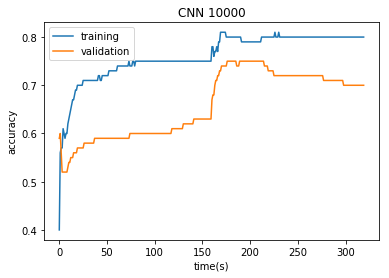

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 355us/step


  1%|          | 1/160 [00:00<02:01,  1.31it/s]

1999/1999 [==============================] - 1s 349us/step


  1%|▏         | 2/160 [00:01<01:59,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


  2%|▏         | 3/160 [00:02<01:58,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


  2%|▎         | 4/160 [00:03<01:57,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


  3%|▎         | 5/160 [00:03<01:56,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


  4%|▍         | 6/160 [00:04<01:55,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


  4%|▍         | 7/160 [00:05<01:54,  1.33it/s]

1999/1999 [==============================] - 1s 356us/step


  5%|▌         | 8/160 [00:06<01:54,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  6%|▌         | 9/160 [00:06<01:53,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


  6%|▋         | 10/160 [00:07<01:52,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


  7%|▋         | 11/160 [00:08<01:51,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  8%|▊         | 12/160 [00:08<01:50,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


  8%|▊         | 13/160 [00:09<01:50,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


  9%|▉         | 14/160 [00:10<01:49,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


  9%|▉         | 15/160 [00:11<01:48,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 10%|█         | 16/160 [00:11<01:48,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 11%|█         | 17/160 [00:12<01:47,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 11%|█▏        | 18/160 [00:13<01:46,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 12%|█▎        | 20/160 [00:14<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 355us/step


 13%|█▎        | 21/160 [00:15<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 14%|█▍        | 22/160 [00:16<01:43,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 15%|█▌        | 24/160 [00:18<01:42,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 16%|█▌        | 25/160 [00:18<01:41,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 16%|█▋        | 26/160 [00:19<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 17%|█▋        | 27/160 [00:20<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 358us/step


 18%|█▊        | 28/160 [00:21<01:39,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 18%|█▊        | 29/160 [00:21<01:38,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 19%|█▉        | 30/160 [00:22<01:37,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


 19%|█▉        | 31/160 [00:23<01:37,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 20%|██        | 32/160 [00:24<01:36,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 21%|██        | 33/160 [00:24<01:35,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 21%|██▏       | 34/160 [00:25<01:34,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▏       | 35/160 [00:26<01:33,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 22%|██▎       | 36/160 [00:27<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 23%|██▎       | 37/160 [00:27<01:31,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 24%|██▍       | 38/160 [00:28<01:31,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 24%|██▍       | 39/160 [00:29<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 25%|██▌       | 40/160 [00:29<01:29,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 26%|██▌       | 41/160 [00:30<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 26%|██▋       | 42/160 [00:31<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 27%|██▋       | 43/160 [00:32<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 28%|██▊       | 45/160 [00:33<01:25,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 29%|██▉       | 46/160 [00:34<01:25,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 29%|██▉       | 47/160 [00:35<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 30%|███       | 48/160 [00:35<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 31%|███       | 49/160 [00:36<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 358us/step


 31%|███▏      | 50/160 [00:37<01:22,  1.33it/s]

1999/1999 [==============================] - 1s 360us/step


 32%|███▏      | 51/160 [00:38<01:22,  1.32it/s]

1999/1999 [==============================] - 1s 365us/step


 32%|███▎      | 52/160 [00:39<01:22,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 33%|███▎      | 53/160 [00:39<01:21,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 34%|███▍      | 54/160 [00:40<01:21,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 34%|███▍      | 55/160 [00:41<01:20,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 35%|███▌      | 56/160 [00:42<01:19,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 36%|███▌      | 57/160 [00:42<01:18,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 36%|███▋      | 58/160 [00:43<01:18,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 37%|███▋      | 59/160 [00:44<01:17,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 38%|███▊      | 60/160 [00:45<01:16,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


 38%|███▊      | 61/160 [00:45<01:15,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


 39%|███▉      | 62/160 [00:46<01:15,  1.31it/s]

1999/1999 [==============================] - 1s 348us/step


 39%|███▉      | 63/160 [00:47<01:13,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 40%|████      | 64/160 [00:48<01:12,  1.32it/s]

1999/1999 [==============================] - 1s 352us/step


 41%|████      | 65/160 [00:48<01:11,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 41%|████▏     | 66/160 [00:49<01:10,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 42%|████▎     | 68/160 [00:51<01:08,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 43%|████▎     | 69/160 [00:51<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 44%|████▍     | 70/160 [00:52<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 44%|████▍     | 71/160 [00:53<01:06,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 45%|████▌     | 72/160 [00:54<01:05,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 46%|████▌     | 73/160 [00:54<01:04,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 46%|████▋     | 74/160 [00:55<01:04,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 47%|████▋     | 75/160 [00:56<01:03,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 76/160 [00:57<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 48%|████▊     | 77/160 [00:57<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 49%|████▉     | 78/160 [00:58<01:01,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 50%|█████     | 80/160 [01:00<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 51%|█████     | 81/160 [01:00<00:59,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 51%|█████▏    | 82/160 [01:01<00:58,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 52%|█████▎    | 84/160 [01:03<00:56,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 53%|█████▎    | 85/160 [01:03<00:56,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 54%|█████▍    | 86/160 [01:04<00:55,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 55%|█████▌    | 88/160 [01:06<00:53,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 56%|█████▌    | 89/160 [01:06<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 57%|█████▋    | 91/160 [01:08<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 57%|█████▊    | 92/160 [01:09<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 58%|█████▊    | 93/160 [01:09<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 59%|█████▉    | 94/160 [01:10<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 59%|█████▉    | 95/160 [01:11<00:48,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 60%|██████    | 96/160 [01:12<00:47,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 61%|██████    | 97/160 [01:12<00:47,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 61%|██████▏   | 98/160 [01:13<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 62%|██████▏   | 99/160 [01:14<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 62%|██████▎   | 100/160 [01:15<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 357us/step


 63%|██████▎   | 101/160 [01:15<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 356us/step


 64%|██████▍   | 103/160 [01:17<00:42,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 65%|██████▌   | 104/160 [01:18<00:41,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 66%|██████▌   | 105/160 [01:18<00:41,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 66%|██████▋   | 106/160 [01:19<00:40,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 67%|██████▋   | 107/160 [01:20<00:39,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 68%|██████▊   | 108/160 [01:21<00:38,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 68%|██████▊   | 109/160 [01:21<00:38,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 69%|██████▉   | 110/160 [01:22<00:37,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 69%|██████▉   | 111/160 [01:23<00:36,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 70%|███████   | 112/160 [01:24<00:35,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 71%|███████   | 113/160 [01:24<00:35,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 71%|███████▏  | 114/160 [01:25<00:34,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 72%|███████▏  | 115/160 [01:26<00:33,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 72%|███████▎  | 116/160 [01:27<00:32,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 73%|███████▎  | 117/160 [01:27<00:32,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 74%|███████▍  | 118/160 [01:28<00:31,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 74%|███████▍  | 119/160 [01:29<00:30,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 75%|███████▌  | 120/160 [01:30<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 77%|███████▋  | 123/160 [01:32<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 78%|███████▊  | 124/160 [01:32<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 79%|███████▉  | 127/160 [01:35<00:24,  1.34it/s]

1999/1999 [==============================] - 1s 357us/step


 80%|████████  | 128/160 [01:35<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 363us/step


 81%|████████  | 129/160 [01:36<00:23,  1.32it/s]

1999/1999 [==============================] - 1s 365us/step


 81%|████████▏ | 130/160 [01:37<00:22,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 82%|████████▏ | 131/160 [01:38<00:22,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 82%|████████▎ | 132/160 [01:39<00:21,  1.30it/s]

1999/1999 [==============================] - 1s 364us/step


 83%|████████▎ | 133/160 [01:39<00:20,  1.30it/s]

1999/1999 [==============================] - 1s 364us/step


 84%|████████▍ | 134/160 [01:40<00:20,  1.30it/s]

1999/1999 [==============================] - 1s 355us/step


 84%|████████▍ | 135/160 [01:41<00:19,  1.30it/s]

1999/1999 [==============================] - 1s 348us/step


 85%|████████▌ | 136/160 [01:42<00:18,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.32it/s]

1999/1999 [==============================] - 1s 352us/step


 86%|████████▋ | 138/160 [01:43<00:16,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 87%|████████▋ | 139/160 [01:44<00:15,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 88%|████████▊ | 140/160 [01:45<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 89%|████████▉ | 142/160 [01:46<00:13,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 89%|████████▉ | 143/160 [01:47<00:12,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 90%|█████████ | 144/160 [01:48<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 91%|█████████▏| 146/160 [01:49<00:10,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 92%|█████████▏| 147/160 [01:50<00:09,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 92%|█████████▎| 148/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 356us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 94%|█████████▍| 150/160 [01:52<00:07,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 94%|█████████▍| 151/160 [01:53<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 95%|█████████▌| 152/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 96%|█████████▋| 154/160 [01:55<00:04,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 97%|█████████▋| 155/160 [01:56<00:03,  1.34it/s]

1999/1999 [==============================] - 1s 355us/step


 98%|█████████▊| 156/160 [01:57<00:02,  1.33it/s]

1999/1999 [==============================] - 1s 360us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.32it/s]

1999/1999 [==============================] - 1s 360us/step


 99%|█████████▉| 158/160 [01:58<00:01,  1.32it/s]

1999/1999 [==============================] - 1s 358us/step


 99%|█████████▉| 159/160 [01:59<00:00,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


100%|██████████| 160/160 [02:00<00:00,  1.31it/s]


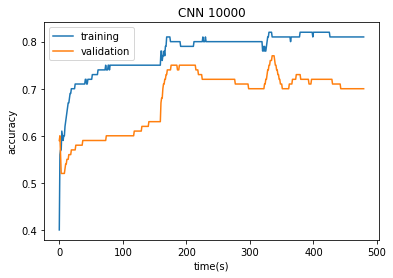

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 363us/step


  1%|          | 1/160 [00:00<02:03,  1.28it/s]

1999/1999 [==============================] - 1s 356us/step


  1%|▏         | 2/160 [00:01<02:02,  1.29it/s]

1999/1999 [==============================] - 1s 360us/step


  2%|▏         | 3/160 [00:02<02:01,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


  2%|▎         | 4/160 [00:03<02:00,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


  3%|▎         | 5/160 [00:03<01:59,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


  4%|▍         | 6/160 [00:04<01:58,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


  4%|▍         | 7/160 [00:05<01:57,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


  5%|▌         | 8/160 [00:06<01:56,  1.30it/s]

1999/1999 [==============================] - 1s 352us/step


  6%|▌         | 9/160 [00:06<01:55,  1.31it/s]

1999/1999 [==============================] - 1s 349us/step


  6%|▋         | 10/160 [00:07<01:53,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


  7%|▋         | 11/160 [00:08<01:52,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


  8%|▊         | 12/160 [00:09<01:51,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


  8%|▊         | 13/160 [00:09<01:50,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


  9%|▉         | 14/160 [00:10<01:49,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 15/160 [00:11<01:48,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 10%|█         | 16/160 [00:12<01:47,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 11%|█         | 17/160 [00:12<01:46,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 12%|█▏        | 19/160 [00:14<01:44,  1.35it/s]

1999/1999 [==============================] - 1s 359us/step


 12%|█▎        | 20/160 [00:15<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 13%|█▎        | 21/160 [00:15<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 14%|█▍        | 22/160 [00:16<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 15%|█▌        | 24/160 [00:18<01:41,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 17%|█▋        | 27/160 [00:20<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 18%|█▊        | 28/160 [00:21<01:38,  1.34it/s]

1999/1999 [==============================] - 1s 374us/step


 18%|█▊        | 29/160 [00:21<01:39,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 19%|█▉        | 30/160 [00:22<01:38,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 19%|█▉        | 31/160 [00:23<01:37,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 20%|██        | 32/160 [00:24<01:36,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 21%|██        | 33/160 [00:24<01:35,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 21%|██▏       | 34/160 [00:25<01:34,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 22%|██▏       | 35/160 [00:26<01:33,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 22%|██▎       | 36/160 [00:27<01:32,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 23%|██▎       | 37/160 [00:27<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 24%|██▍       | 38/160 [00:28<01:31,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 24%|██▍       | 39/160 [00:29<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 25%|██▌       | 40/160 [00:30<01:29,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 26%|██▌       | 41/160 [00:30<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 26%|██▋       | 42/160 [00:31<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 27%|██▋       | 43/160 [00:32<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 356us/step


 28%|██▊       | 44/160 [00:33<01:26,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 28%|██▊       | 45/160 [00:33<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 356us/step


 29%|██▉       | 46/160 [00:34<01:25,  1.33it/s]

1999/1999 [==============================] - 1s 356us/step


 29%|██▉       | 47/160 [00:35<01:25,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 30%|███       | 48/160 [00:36<01:24,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 31%|███       | 49/160 [00:36<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 31%|███▏      | 50/160 [00:37<01:22,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 32%|███▏      | 51/160 [00:38<01:21,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 32%|███▎      | 52/160 [00:39<01:20,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 33%|███▎      | 53/160 [00:39<01:19,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 34%|███▍      | 54/160 [00:40<01:18,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 34%|███▍      | 55/160 [00:41<01:18,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 35%|███▌      | 56/160 [00:42<01:17,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 36%|███▌      | 57/160 [00:42<01:16,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 36%|███▋      | 58/160 [00:43<01:15,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 37%|███▋      | 59/160 [00:44<01:15,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 38%|███▊      | 60/160 [00:44<01:14,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 38%|███▊      | 61/160 [00:45<01:13,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 39%|███▉      | 62/160 [00:46<01:12,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 39%|███▉      | 63/160 [00:47<01:12,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 40%|████      | 64/160 [00:47<01:11,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 41%|████      | 65/160 [00:48<01:10,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 41%|████▏     | 66/160 [00:49<01:09,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 42%|████▎     | 68/160 [00:50<01:08,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 43%|████▎     | 69/160 [00:51<01:07,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 44%|████▍     | 70/160 [00:52<01:06,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 44%|████▍     | 71/160 [00:53<01:06,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 45%|████▌     | 72/160 [00:53<01:05,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 46%|████▌     | 73/160 [00:54<01:04,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 46%|████▋     | 74/160 [00:55<01:04,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 47%|████▋     | 75/160 [00:56<01:03,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 48%|████▊     | 76/160 [00:56<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 48%|████▊     | 77/160 [00:57<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 49%|████▉     | 78/160 [00:58<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 50%|█████     | 80/160 [00:59<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 51%|█████     | 81/160 [01:00<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 51%|█████▏    | 82/160 [01:01<00:58,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 52%|█████▎    | 84/160 [01:02<00:56,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 54%|█████▍    | 86/160 [01:04<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 55%|█████▌    | 88/160 [01:05<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 56%|█████▌    | 89/160 [01:06<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 57%|█████▋    | 91/160 [01:08<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 57%|█████▊    | 92/160 [01:08<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 58%|█████▊    | 93/160 [01:09<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 59%|█████▉    | 94/160 [01:10<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 59%|█████▉    | 95/160 [01:11<00:48,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 60%|██████    | 96/160 [01:11<00:47,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 61%|██████    | 97/160 [01:12<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 61%|██████▏   | 98/160 [01:13<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 62%|██████▏   | 99/160 [01:14<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 62%|██████▎   | 100/160 [01:14<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 63%|██████▎   | 101/160 [01:15<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 357us/step


 64%|██████▍   | 103/160 [01:17<00:42,  1.33it/s]

1999/1999 [==============================] - 1s 361us/step


 65%|██████▌   | 104/160 [01:17<00:42,  1.32it/s]

1999/1999 [==============================] - 1s 360us/step


 66%|██████▌   | 105/160 [01:18<00:41,  1.32it/s]

1999/1999 [==============================] - 1s 358us/step


 66%|██████▋   | 106/160 [01:19<00:41,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 67%|██████▋   | 107/160 [01:20<00:40,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 68%|██████▊   | 108/160 [01:20<00:39,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 68%|██████▊   | 109/160 [01:21<00:39,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 69%|██████▉   | 110/160 [01:22<00:38,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 69%|██████▉   | 111/160 [01:23<00:37,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


 70%|███████   | 112/160 [01:23<00:36,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


 71%|███████   | 113/160 [01:24<00:35,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 71%|███████▏  | 114/160 [01:25<00:35,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


 72%|███████▏  | 115/160 [01:26<00:34,  1.30it/s]

1999/1999 [==============================] - 1s 356us/step


 72%|███████▎  | 116/160 [01:27<00:33,  1.31it/s]

1999/1999 [==============================] - 1s 350us/step


 73%|███████▎  | 117/160 [01:27<00:32,  1.32it/s]

1999/1999 [==============================] - 1s 351us/step


 74%|███████▍  | 118/160 [01:28<00:31,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 74%|███████▍  | 119/160 [01:29<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 75%|███████▌  | 120/160 [01:30<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 77%|███████▋  | 123/160 [01:32<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 360us/step


 78%|███████▊  | 124/160 [01:33<00:27,  1.33it/s]

1999/1999 [==============================] - 1s 366us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.32it/s]

1999/1999 [==============================] - 1s 364us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.31it/s]

1999/1999 [==============================] - 1s 368us/step


 79%|███████▉  | 127/160 [01:35<00:25,  1.30it/s]

1999/1999 [==============================] - 1s 367us/step


 80%|████████  | 128/160 [01:36<00:24,  1.29it/s]

1999/1999 [==============================] - 1s 368us/step


 81%|████████  | 129/160 [01:36<00:24,  1.29it/s]

1999/1999 [==============================] - 1s 365us/step


 81%|████████▏ | 130/160 [01:37<00:23,  1.29it/s]

1999/1999 [==============================] - 1s 365us/step


 82%|████████▏ | 131/160 [01:38<00:22,  1.29it/s]

1999/1999 [==============================] - 1s 365us/step


 82%|████████▎ | 132/160 [01:39<00:21,  1.28it/s]

1999/1999 [==============================] - 1s 366us/step


 83%|████████▎ | 133/160 [01:40<00:21,  1.28it/s]

1999/1999 [==============================] - 1s 370us/step


 84%|████████▍ | 134/160 [01:40<00:20,  1.28it/s]

1999/1999 [==============================] - 1s 362us/step


 84%|████████▍ | 135/160 [01:41<00:19,  1.29it/s]

1999/1999 [==============================] - 1s 366us/step


 85%|████████▌ | 136/160 [01:42<00:18,  1.29it/s]

1999/1999 [==============================] - 1s 359us/step


 86%|████████▌ | 137/160 [01:43<00:17,  1.29it/s]

1999/1999 [==============================] - 1s 353us/step


 86%|████████▋ | 138/160 [01:43<00:16,  1.30it/s]

1999/1999 [==============================] - 1s 348us/step


 87%|████████▋ | 139/160 [01:44<00:15,  1.32it/s]

1999/1999 [==============================] - 1s 348us/step


 88%|████████▊ | 140/160 [01:45<00:15,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 88%|████████▊ | 141/160 [01:46<00:14,  1.33it/s]

1999/1999 [==============================] - 1s 357us/step


 89%|████████▉ | 142/160 [01:46<00:13,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 89%|████████▉ | 143/160 [01:47<00:12,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 90%|█████████ | 144/160 [01:48<00:11,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 91%|█████████ | 145/160 [01:49<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 91%|█████████▏| 146/160 [01:49<00:10,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 92%|█████████▏| 147/160 [01:50<00:09,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 92%|█████████▎| 148/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 93%|█████████▎| 149/160 [01:52<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 94%|█████████▍| 150/160 [01:52<00:07,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 94%|█████████▍| 151/160 [01:53<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 95%|█████████▌| 152/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 96%|█████████▌| 153/160 [01:55<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 96%|█████████▋| 154/160 [01:55<00:04,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 97%|█████████▋| 155/160 [01:56<00:03,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 98%|█████████▊| 156/160 [01:57<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 98%|█████████▊| 157/160 [01:58<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 99%|█████████▉| 158/160 [01:58<00:01,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 99%|█████████▉| 159/160 [01:59<00:00,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


100%|██████████| 160/160 [02:00<00:00,  1.34it/s]


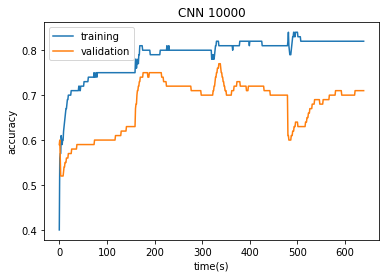

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 352us/step


  1%|          | 1/160 [00:00<01:59,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


  1%|▏         | 2/160 [00:01<01:58,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


  2%|▏         | 3/160 [00:02<01:57,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  2%|▎         | 4/160 [00:02<01:56,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


  3%|▎         | 5/160 [00:03<01:55,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


  4%|▍         | 6/160 [00:04<01:54,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  4%|▍         | 7/160 [00:05<01:54,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  5%|▌         | 8/160 [00:05<01:53,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  6%|▌         | 9/160 [00:06<01:52,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


  6%|▋         | 10/160 [00:07<01:51,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  7%|▋         | 11/160 [00:08<01:51,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


  8%|▊         | 12/160 [00:08<01:50,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  8%|▊         | 13/160 [00:09<01:49,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  9%|▉         | 14/160 [00:10<01:49,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  9%|▉         | 15/160 [00:11<01:48,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 10%|█         | 16/160 [00:11<01:47,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 11%|█         | 17/160 [00:12<01:46,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 358us/step


 12%|█▎        | 20/160 [00:14<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 13%|█▎        | 21/160 [00:15<01:44,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 14%|█▍        | 22/160 [00:16<01:43,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 15%|█▌        | 24/160 [00:17<01:41,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 16%|█▋        | 26/160 [00:19<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 17%|█▋        | 27/160 [00:20<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 18%|█▊        | 28/160 [00:20<01:38,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 18%|█▊        | 29/160 [00:21<01:38,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 19%|█▉        | 30/160 [00:22<01:37,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 19%|█▉        | 31/160 [00:23<01:36,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 20%|██        | 32/160 [00:23<01:35,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 21%|██        | 33/160 [00:24<01:34,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.34it/s]

1999/1999 [==============================] - 1s 357us/step


 22%|██▏       | 35/160 [00:26<01:33,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▎       | 36/160 [00:26<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 23%|██▎       | 37/160 [00:27<01:32,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 24%|██▍       | 38/160 [00:28<01:31,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 24%|██▍       | 39/160 [00:29<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 25%|██▌       | 40/160 [00:29<01:29,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 26%|██▌       | 41/160 [00:30<01:29,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 26%|██▋       | 42/160 [00:31<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 27%|██▋       | 43/160 [00:32<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 28%|██▊       | 45/160 [00:33<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 29%|██▉       | 46/160 [00:34<01:25,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 29%|██▉       | 47/160 [00:35<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 30%|███       | 48/160 [00:35<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 355us/step


 31%|███       | 49/160 [00:36<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 362us/step


 31%|███▏      | 50/160 [00:37<01:23,  1.32it/s]

1999/1999 [==============================] - 1s 359us/step


 32%|███▏      | 51/160 [00:38<01:22,  1.32it/s]

1999/1999 [==============================] - 1s 360us/step


 32%|███▎      | 52/160 [00:38<01:22,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 33%|███▎      | 53/160 [00:39<01:21,  1.31it/s]

1999/1999 [==============================] - 1s 357us/step


 34%|███▍      | 54/160 [00:40<01:20,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 34%|███▍      | 55/160 [00:41<01:20,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 35%|███▌      | 56/160 [00:41<01:19,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


 36%|███▌      | 57/160 [00:42<01:18,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 36%|███▋      | 58/160 [00:43<01:18,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


 37%|███▋      | 59/160 [00:44<01:17,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


 38%|███▊      | 60/160 [00:45<01:16,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 38%|███▊      | 61/160 [00:45<01:15,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


 39%|███▉      | 62/160 [00:46<01:15,  1.30it/s]

1999/1999 [==============================] - 1s 350us/step


 39%|███▉      | 63/160 [00:47<01:13,  1.31it/s]

1999/1999 [==============================] - 1s 349us/step


 40%|████      | 64/160 [00:48<01:12,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


 41%|████      | 65/160 [00:48<01:11,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 41%|████▏     | 66/160 [00:49<01:10,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 42%|████▎     | 68/160 [00:51<01:08,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 43%|████▎     | 69/160 [00:51<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 44%|████▍     | 70/160 [00:52<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 44%|████▍     | 71/160 [00:53<01:06,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 45%|████▌     | 72/160 [00:54<01:05,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 46%|████▌     | 73/160 [00:54<01:04,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 46%|████▋     | 74/160 [00:55<01:03,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 47%|████▋     | 75/160 [00:56<01:03,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 76/160 [00:57<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 48%|████▊     | 77/160 [00:57<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 49%|████▉     | 78/160 [00:58<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 50%|█████     | 80/160 [01:00<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 51%|█████     | 81/160 [01:00<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 51%|█████▏    | 82/160 [01:01<00:58,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 52%|█████▎    | 84/160 [01:02<00:56,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 54%|█████▍    | 86/160 [01:04<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 55%|█████▌    | 88/160 [01:05<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 56%|█████▌    | 89/160 [01:06<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 355us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 57%|█████▋    | 91/160 [01:08<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 57%|█████▊    | 92/160 [01:08<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 58%|█████▊    | 93/160 [01:09<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 59%|█████▉    | 94/160 [01:10<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 59%|█████▉    | 95/160 [01:11<00:48,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 60%|██████    | 96/160 [01:11<00:47,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 61%|██████    | 97/160 [01:12<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 61%|██████▏   | 98/160 [01:13<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 62%|██████▏   | 99/160 [01:14<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 62%|██████▎   | 100/160 [01:14<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 63%|██████▎   | 101/160 [01:15<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 64%|██████▍   | 103/160 [01:17<00:42,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 65%|██████▌   | 104/160 [01:17<00:41,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 66%|██████▌   | 105/160 [01:18<00:40,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 66%|██████▋   | 106/160 [01:19<00:40,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 67%|██████▋   | 107/160 [01:20<00:39,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 68%|██████▊   | 108/160 [01:20<00:38,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 68%|██████▊   | 109/160 [01:21<00:37,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 69%|██████▉   | 110/160 [01:22<00:37,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 69%|██████▉   | 111/160 [01:23<00:36,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 70%|███████   | 112/160 [01:23<00:35,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 71%|███████   | 113/160 [01:24<00:34,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 71%|███████▏  | 114/160 [01:25<00:34,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 72%|███████▏  | 115/160 [01:26<00:33,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 72%|███████▎  | 116/160 [01:26<00:32,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 73%|███████▎  | 117/160 [01:27<00:32,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 74%|███████▍  | 118/160 [01:28<00:31,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 74%|███████▍  | 119/160 [01:29<00:30,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 75%|███████▌  | 120/160 [01:29<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 77%|███████▋  | 123/160 [01:32<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 78%|███████▊  | 124/160 [01:32<00:26,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 79%|███████▉  | 127/160 [01:35<00:24,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 80%|████████  | 128/160 [01:35<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 81%|████████  | 129/160 [01:36<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 81%|████████▏ | 130/160 [01:37<00:22,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 82%|████████▏ | 131/160 [01:38<00:21,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 82%|████████▎ | 132/160 [01:38<00:20,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 83%|████████▎ | 133/160 [01:39<00:20,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 84%|████████▍ | 134/160 [01:40<00:19,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 84%|████████▍ | 135/160 [01:40<00:18,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 85%|████████▌ | 136/160 [01:41<00:17,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 86%|████████▋ | 138/160 [01:43<00:16,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 87%|████████▋ | 139/160 [01:43<00:15,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 88%|████████▊ | 140/160 [01:44<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 89%|████████▉ | 142/160 [01:46<00:13,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 89%|████████▉ | 143/160 [01:46<00:12,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 90%|█████████ | 144/160 [01:47<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 91%|█████████▏| 146/160 [01:49<00:10,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 92%|█████████▏| 147/160 [01:49<00:09,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 92%|█████████▎| 148/160 [01:50<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 94%|█████████▍| 150/160 [01:52<00:07,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 94%|█████████▍| 151/160 [01:52<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 95%|█████████▌| 152/160 [01:53<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 96%|█████████▋| 154/160 [01:55<00:04,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 97%|█████████▋| 155/160 [01:55<00:03,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 98%|█████████▊| 156/160 [01:56<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 365us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.32it/s]

1999/1999 [==============================] - 1s 358us/step


 99%|█████████▉| 158/160 [01:58<00:01,  1.32it/s]

1999/1999 [==============================] - 1s 359us/step


 99%|█████████▉| 159/160 [01:58<00:00,  1.32it/s]

1999/1999 [==============================] - 1s 363us/step


100%|██████████| 160/160 [01:59<00:00,  1.31it/s]


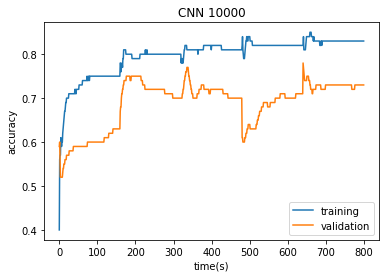

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 363us/step


  1%|          | 1/160 [00:00<02:03,  1.28it/s]

1999/1999 [==============================] - 1s 360us/step


  1%|▏         | 2/160 [00:01<02:02,  1.29it/s]

1999/1999 [==============================] - 1s 360us/step


  2%|▏         | 3/160 [00:02<02:01,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


  2%|▎         | 4/160 [00:03<02:00,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


  3%|▎         | 5/160 [00:03<01:59,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


  4%|▍         | 6/160 [00:04<01:58,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


  4%|▍         | 7/160 [00:05<01:57,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


  5%|▌         | 8/160 [00:06<01:56,  1.31it/s]

1999/1999 [==============================] - 1s 357us/step


  6%|▌         | 9/160 [00:06<01:55,  1.31it/s]

1999/1999 [==============================] - 1s 350us/step


  6%|▋         | 10/160 [00:07<01:53,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


  7%|▋         | 11/160 [00:08<01:52,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  8%|▊         | 12/160 [00:09<01:51,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  8%|▊         | 13/160 [00:09<01:49,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 14/160 [00:10<01:48,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 15/160 [00:11<01:48,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 10%|█         | 16/160 [00:12<01:47,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 11%|█         | 17/160 [00:12<01:46,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.35it/s]

1999/1999 [==============================] - 1s 358us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 12%|█▎        | 20/160 [00:15<01:44,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 13%|█▎        | 21/160 [00:15<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 14%|█▍        | 22/160 [00:16<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 15%|█▌        | 24/160 [00:18<01:41,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 17%|█▋        | 27/160 [00:20<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 18%|█▊        | 28/160 [00:21<01:38,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 18%|█▊        | 29/160 [00:21<01:37,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 19%|█▉        | 30/160 [00:22<01:36,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 19%|█▉        | 31/160 [00:23<01:36,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 20%|██        | 32/160 [00:24<01:35,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 21%|██        | 33/160 [00:24<01:34,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 22%|██▏       | 35/160 [00:26<01:33,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▎       | 36/160 [00:27<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 369us/step


 23%|██▎       | 37/160 [00:27<01:32,  1.32it/s]

1999/1999 [==============================] - 1s 352us/step


 24%|██▍       | 38/160 [00:28<01:32,  1.33it/s]

1999/1999 [==============================] - 1s 355us/step


 24%|██▍       | 39/160 [00:29<01:31,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 25%|██▌       | 40/160 [00:30<01:30,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 26%|██▌       | 41/160 [00:30<01:29,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 26%|██▋       | 42/160 [00:31<01:28,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 27%|██▋       | 43/160 [00:32<01:27,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 28%|██▊       | 44/160 [00:33<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 28%|██▊       | 45/160 [00:33<01:26,  1.33it/s]

1999/1999 [==============================] - 1s 353us/step


 29%|██▉       | 46/160 [00:34<01:25,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 29%|██▉       | 47/160 [00:35<01:24,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 30%|███       | 48/160 [00:36<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 31%|███       | 49/160 [00:36<01:22,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 31%|███▏      | 50/160 [00:37<01:22,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 32%|███▏      | 51/160 [00:38<01:21,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 32%|███▎      | 52/160 [00:39<01:20,  1.34it/s]

1999/1999 [==============================] - 1s 355us/step


 33%|███▎      | 53/160 [00:39<01:20,  1.34it/s]

1999/1999 [==============================] - 1s 361us/step


 34%|███▍      | 54/160 [00:40<01:20,  1.32it/s]

1999/1999 [==============================] - 1s 361us/step


 34%|███▍      | 55/160 [00:41<01:19,  1.32it/s]

1999/1999 [==============================] - 1s 361us/step


 35%|███▌      | 56/160 [00:42<01:19,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 36%|███▌      | 57/160 [00:42<01:18,  1.31it/s]

1999/1999 [==============================] - 1s 363us/step


 36%|███▋      | 58/160 [00:43<01:18,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


 37%|███▋      | 59/160 [00:44<01:17,  1.30it/s]

1999/1999 [==============================] - 1s 354us/step


 38%|███▊      | 60/160 [00:45<01:16,  1.31it/s]

1999/1999 [==============================] - 1s 351us/step


 38%|███▊      | 61/160 [00:45<01:15,  1.32it/s]

1999/1999 [==============================] - 1s 347us/step


 39%|███▉      | 62/160 [00:46<01:13,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 39%|███▉      | 63/160 [00:47<01:12,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 40%|████      | 64/160 [00:48<01:11,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 41%|████      | 65/160 [00:48<01:10,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 41%|████▏     | 66/160 [00:49<01:10,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 42%|████▎     | 68/160 [00:51<01:08,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 43%|████▎     | 69/160 [00:51<01:07,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 44%|████▍     | 70/160 [00:52<01:06,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 44%|████▍     | 71/160 [00:53<01:06,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 45%|████▌     | 72/160 [00:54<01:05,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 46%|████▌     | 73/160 [00:54<01:04,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 46%|████▋     | 74/160 [00:55<01:03,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 47%|████▋     | 75/160 [00:56<01:03,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 76/160 [00:57<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 48%|████▊     | 77/160 [00:57<01:02,  1.33it/s]

1999/1999 [==============================] - 1s 352us/step


 49%|████▉     | 78/160 [00:58<01:01,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 50%|█████     | 80/160 [01:00<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 51%|█████     | 81/160 [01:00<00:58,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 51%|█████▏    | 82/160 [01:01<00:58,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 52%|█████▎    | 84/160 [01:03<00:56,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 54%|█████▍    | 86/160 [01:04<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 55%|█████▌    | 88/160 [01:06<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 56%|█████▌    | 89/160 [01:06<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 57%|█████▋    | 91/160 [01:08<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 57%|█████▊    | 92/160 [01:08<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 58%|█████▊    | 93/160 [01:09<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 59%|█████▉    | 94/160 [01:10<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 59%|█████▉    | 95/160 [01:11<00:48,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 60%|██████    | 96/160 [01:11<00:47,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 61%|██████    | 97/160 [01:12<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 61%|██████▏   | 98/160 [01:13<00:46,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 62%|██████▏   | 99/160 [01:14<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 62%|██████▎   | 100/160 [01:14<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 63%|██████▎   | 101/160 [01:15<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 64%|██████▍   | 103/160 [01:17<00:42,  1.34it/s]

1999/1999 [==============================] - 1s 363us/step


 65%|██████▌   | 104/160 [01:17<00:42,  1.32it/s]

1999/1999 [==============================] - 1s 365us/step


 66%|██████▌   | 105/160 [01:18<00:41,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 66%|██████▋   | 106/160 [01:19<00:41,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 67%|██████▋   | 107/160 [01:20<00:40,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 68%|██████▊   | 108/160 [01:21<00:39,  1.31it/s]

1999/1999 [==============================] - 1s 361us/step


 68%|██████▊   | 109/160 [01:21<00:39,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 69%|██████▉   | 110/160 [01:22<00:38,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 69%|██████▉   | 111/160 [01:23<00:37,  1.31it/s]

1999/1999 [==============================] - 1s 382us/step


 70%|███████   | 112/160 [01:24<00:37,  1.28it/s]

1999/1999 [==============================] - 1s 361us/step


 71%|███████   | 113/160 [01:24<00:36,  1.29it/s]

1999/1999 [==============================] - 1s 365us/step


 71%|███████▏  | 114/160 [01:25<00:35,  1.29it/s]

1999/1999 [==============================] - 1s 361us/step


 72%|███████▏  | 115/160 [01:26<00:34,  1.29it/s]

1999/1999 [==============================] - 1s 367us/step


 72%|███████▎  | 116/160 [01:27<00:34,  1.29it/s]

1999/1999 [==============================] - 1s 349us/step


 73%|███████▎  | 117/160 [01:27<00:32,  1.30it/s]

1999/1999 [==============================] - 1s 351us/step


 74%|███████▍  | 118/160 [01:28<00:31,  1.31it/s]

1999/1999 [==============================] - 1s 349us/step


 74%|███████▍  | 119/160 [01:29<00:30,  1.32it/s]

1999/1999 [==============================] - 1s 348us/step


 75%|███████▌  | 120/160 [01:30<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 77%|███████▋  | 123/160 [01:32<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 78%|███████▊  | 124/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 79%|███████▉  | 127/160 [01:35<00:24,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 80%|████████  | 128/160 [01:36<00:23,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 81%|████████  | 129/160 [01:36<00:23,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 81%|████████▏ | 130/160 [01:37<00:22,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 82%|████████▏ | 131/160 [01:38<00:21,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 82%|████████▎ | 132/160 [01:39<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 83%|████████▎ | 133/160 [01:39<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 84%|████████▍ | 134/160 [01:40<00:19,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 84%|████████▍ | 135/160 [01:41<00:18,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 85%|████████▌ | 136/160 [01:42<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 86%|████████▋ | 138/160 [01:43<00:16,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 87%|████████▋ | 139/160 [01:44<00:15,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 88%|████████▊ | 140/160 [01:45<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 89%|████████▉ | 142/160 [01:46<00:13,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 89%|████████▉ | 143/160 [01:47<00:12,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 90%|█████████ | 144/160 [01:48<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 91%|█████████▏| 146/160 [01:49<00:10,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 92%|█████████▏| 147/160 [01:50<00:09,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 92%|█████████▎| 148/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 94%|█████████▍| 150/160 [01:52<00:07,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 94%|█████████▍| 151/160 [01:53<00:06,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 95%|█████████▌| 152/160 [01:54<00:05,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 96%|█████████▋| 154/160 [01:55<00:04,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 97%|█████████▋| 155/160 [01:56<00:03,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 98%|█████████▊| 156/160 [01:56<00:02,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 99%|█████████▉| 158/160 [01:58<00:01,  1.35it/s]

1999/1999 [==============================] - 1s 357us/step


 99%|█████████▉| 159/160 [01:59<00:00,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


100%|██████████| 160/160 [01:59<00:00,  1.34it/s]


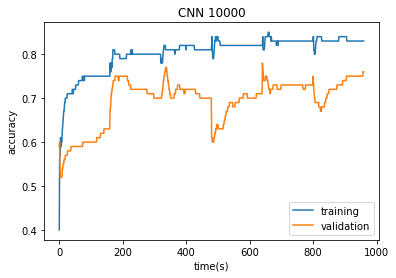

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 354us/step


  1%|          | 1/160 [00:00<02:00,  1.32it/s]

1999/1999 [==============================] - 1s 347us/step


  1%|▏         | 2/160 [00:01<01:59,  1.33it/s]

1999/1999 [==============================] - 1s 346us/step


  2%|▏         | 3/160 [00:02<01:57,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


  2%|▎         | 4/160 [00:02<01:56,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  3%|▎         | 5/160 [00:03<01:55,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  4%|▍         | 6/160 [00:04<01:54,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


  4%|▍         | 7/160 [00:05<01:53,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


  5%|▌         | 8/160 [00:05<01:52,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


  6%|▌         | 9/160 [00:06<01:52,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


  6%|▋         | 10/160 [00:07<01:51,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


  7%|▋         | 11/160 [00:08<01:50,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


  8%|▊         | 12/160 [00:08<01:49,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


  8%|▊         | 13/160 [00:09<01:49,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 14/160 [00:10<01:48,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 15/160 [00:11<01:47,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 10%|█         | 16/160 [00:11<01:46,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 11%|█         | 17/160 [00:12<01:46,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.35it/s]

1999/1999 [==============================] - 1s 356us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 12%|█▎        | 20/160 [00:14<01:44,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 13%|█▎        | 21/160 [00:15<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 14%|█▍        | 22/160 [00:16<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 15%|█▌        | 24/160 [00:17<01:41,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 17%|█▋        | 27/160 [00:20<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 18%|█▊        | 28/160 [00:20<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 18%|█▊        | 29/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 19%|█▉        | 30/160 [00:22<01:36,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 19%|█▉        | 31/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 20%|██        | 32/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 21%|██        | 33/160 [00:24<01:34,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 22%|██▏       | 35/160 [00:26<01:33,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▎       | 36/160 [00:26<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 23%|██▎       | 37/160 [00:27<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 24%|██▍       | 38/160 [00:28<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 24%|██▍       | 39/160 [00:29<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 25%|██▌       | 40/160 [00:29<01:29,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 26%|██▌       | 41/160 [00:30<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 26%|██▋       | 42/160 [00:31<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 27%|██▋       | 43/160 [00:31<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 28%|██▊       | 45/160 [00:33<01:25,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 29%|██▉       | 46/160 [00:34<01:25,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 29%|██▉       | 47/160 [00:34<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 30%|███       | 48/160 [00:35<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 31%|███       | 49/160 [00:36<01:22,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 31%|███▏      | 50/160 [00:37<01:22,  1.34it/s]

1999/1999 [==============================] - 1s 358us/step


 32%|███▏      | 51/160 [00:37<01:22,  1.33it/s]

1999/1999 [==============================] - 1s 358us/step


 32%|███▎      | 52/160 [00:38<01:21,  1.32it/s]

1999/1999 [==============================] - 1s 357us/step


 33%|███▎      | 53/160 [00:39<01:21,  1.32it/s]

1999/1999 [==============================] - 1s 366us/step


 34%|███▍      | 54/160 [00:40<01:20,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 34%|███▍      | 55/160 [00:41<01:20,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 35%|███▌      | 56/160 [00:41<01:19,  1.31it/s]

1999/1999 [==============================] - 1s 366us/step


 36%|███▌      | 57/160 [00:42<01:19,  1.30it/s]

1999/1999 [==============================] - 1s 365us/step


 36%|███▋      | 58/160 [00:43<01:18,  1.30it/s]

1999/1999 [==============================] - 1s 367us/step


 37%|███▋      | 59/160 [00:44<01:18,  1.29it/s]

1999/1999 [==============================] - 1s 367us/step


 38%|███▊      | 60/160 [00:44<01:17,  1.29it/s]

1999/1999 [==============================] - 1s 368us/step


 38%|███▊      | 61/160 [00:45<01:17,  1.28it/s]

1999/1999 [==============================] - 1s 368us/step


 39%|███▉      | 62/160 [00:46<01:16,  1.28it/s]

1999/1999 [==============================] - 1s 368us/step


 39%|███▉      | 63/160 [00:47<01:15,  1.28it/s]

1999/1999 [==============================] - 1s 363us/step


 40%|████      | 64/160 [00:48<01:14,  1.28it/s]

1999/1999 [==============================] - 1s 365us/step


 41%|████      | 65/160 [00:48<01:13,  1.28it/s]

1999/1999 [==============================] - 1s 365us/step


 41%|████▏     | 66/160 [00:49<01:13,  1.28it/s]

1999/1999 [==============================] - 1s 363us/step


 42%|████▏     | 67/160 [00:50<01:12,  1.29it/s]

1999/1999 [==============================] - 1s 366us/step


 42%|████▎     | 68/160 [00:51<01:11,  1.28it/s]

1999/1999 [==============================] - 1s 366us/step


 43%|████▎     | 69/160 [00:51<01:10,  1.28it/s]

1999/1999 [==============================] - 1s 350us/step


 44%|████▍     | 70/160 [00:52<01:09,  1.30it/s]

1999/1999 [==============================] - 1s 348us/step


 44%|████▍     | 71/160 [00:53<01:07,  1.31it/s]

1999/1999 [==============================] - 1s 349us/step


 45%|████▌     | 72/160 [00:54<01:06,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


 46%|████▌     | 73/160 [00:54<01:05,  1.33it/s]

1999/1999 [==============================] - 1s 351us/step


 46%|████▋     | 74/160 [00:55<01:04,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 47%|████▋     | 75/160 [00:56<01:03,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 48%|████▊     | 76/160 [00:57<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 48%|████▊     | 77/160 [00:57<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 49%|████▉     | 78/160 [00:58<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 50%|█████     | 80/160 [01:00<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 51%|█████     | 81/160 [01:00<00:58,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 51%|█████▏    | 82/160 [01:01<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 52%|█████▎    | 84/160 [01:03<00:56,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 54%|█████▍    | 86/160 [01:04<00:54,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.35it/s]

1999/1999 [==============================] - 1s 353us/step


 55%|█████▌    | 88/160 [01:06<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 56%|█████▌    | 89/160 [01:06<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 345us/step


 57%|█████▋    | 91/160 [01:08<00:51,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 57%|█████▊    | 92/160 [01:09<00:50,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 58%|█████▊    | 93/160 [01:09<00:49,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 59%|█████▉    | 94/160 [01:10<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 59%|█████▉    | 95/160 [01:11<00:48,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 60%|██████    | 96/160 [01:12<00:47,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 61%|██████    | 97/160 [01:12<00:46,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 61%|██████▏   | 98/160 [01:13<00:46,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 62%|██████▏   | 99/160 [01:14<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 62%|██████▎   | 100/160 [01:15<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 63%|██████▎   | 101/160 [01:15<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 64%|██████▍   | 103/160 [01:17<00:42,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 65%|██████▌   | 104/160 [01:17<00:41,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 66%|██████▌   | 105/160 [01:18<00:40,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 66%|██████▋   | 106/160 [01:19<00:40,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 67%|██████▋   | 107/160 [01:20<00:39,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 68%|██████▊   | 108/160 [01:20<00:38,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 68%|██████▊   | 109/160 [01:21<00:37,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 69%|██████▉   | 110/160 [01:22<00:37,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 69%|██████▉   | 111/160 [01:23<00:36,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 70%|███████   | 112/160 [01:23<00:35,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 71%|███████   | 113/160 [01:24<00:34,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 71%|███████▏  | 114/160 [01:25<00:34,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 72%|███████▏  | 115/160 [01:26<00:33,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 72%|███████▎  | 116/160 [01:26<00:32,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 73%|███████▎  | 117/160 [01:27<00:32,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 74%|███████▍  | 118/160 [01:28<00:31,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 74%|███████▍  | 119/160 [01:29<00:30,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 75%|███████▌  | 120/160 [01:29<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 77%|███████▋  | 123/160 [01:32<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 78%|███████▊  | 124/160 [01:32<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 79%|███████▉  | 127/160 [01:35<00:24,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 80%|████████  | 128/160 [01:35<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 81%|████████  | 129/160 [01:36<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 81%|████████▏ | 130/160 [01:37<00:22,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 82%|████████▏ | 131/160 [01:38<00:21,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 82%|████████▎ | 132/160 [01:38<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 83%|████████▎ | 133/160 [01:39<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 353us/step


 84%|████████▍ | 134/160 [01:40<00:19,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 84%|████████▍ | 135/160 [01:41<00:18,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 85%|████████▌ | 136/160 [01:41<00:17,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 86%|████████▋ | 138/160 [01:43<00:16,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 87%|████████▋ | 139/160 [01:44<00:15,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 88%|████████▊ | 140/160 [01:44<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 89%|████████▉ | 142/160 [01:46<00:13,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 89%|████████▉ | 143/160 [01:47<00:12,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 90%|█████████ | 144/160 [01:47<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 91%|█████████▏| 146/160 [01:49<00:10,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 92%|█████████▏| 147/160 [01:49<00:09,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 92%|█████████▎| 148/160 [01:50<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 94%|█████████▍| 150/160 [01:52<00:07,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 94%|█████████▍| 151/160 [01:52<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 95%|█████████▌| 152/160 [01:53<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 96%|█████████▋| 154/160 [01:55<00:04,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 97%|█████████▋| 155/160 [01:55<00:03,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 98%|█████████▊| 156/160 [01:56<00:02,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 361us/step


 99%|█████████▉| 158/160 [01:58<00:01,  1.33it/s]

1999/1999 [==============================] - 1s 364us/step


 99%|█████████▉| 159/160 [01:58<00:00,  1.32it/s]

1999/1999 [==============================] - 1s 361us/step


100%|██████████| 160/160 [01:59<00:00,  1.31it/s]


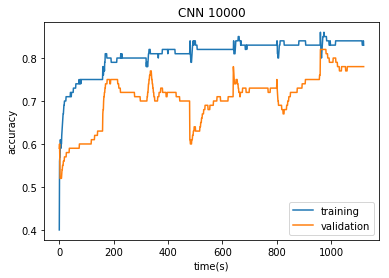

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 364us/step


  1%|          | 1/160 [00:00<02:04,  1.27it/s]

1999/1999 [==============================] - 1s 364us/step


  1%|▏         | 2/160 [00:01<02:03,  1.28it/s]

1999/1999 [==============================] - 1s 361us/step


  2%|▏         | 3/160 [00:02<02:02,  1.28it/s]

1999/1999 [==============================] - 1s 359us/step


  2%|▎         | 4/160 [00:03<02:00,  1.29it/s]

1999/1999 [==============================] - 1s 361us/step


  3%|▎         | 5/160 [00:03<01:59,  1.29it/s]

1999/1999 [==============================] - 1s 359us/step


  4%|▍         | 6/160 [00:04<01:58,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


  4%|▍         | 7/160 [00:05<01:57,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


  5%|▌         | 8/160 [00:06<01:56,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


  6%|▌         | 9/160 [00:06<01:56,  1.30it/s]

1999/1999 [==============================] - 1s 351us/step


  6%|▋         | 10/160 [00:07<01:54,  1.31it/s]

1999/1999 [==============================] - 1s 351us/step


  7%|▋         | 11/160 [00:08<01:53,  1.32it/s]

1999/1999 [==============================] - 1s 347us/step


  8%|▊         | 12/160 [00:09<01:51,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


  8%|▊         | 13/160 [00:09<01:50,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 14/160 [00:10<01:49,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 15/160 [00:11<01:48,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 10%|█         | 16/160 [00:12<01:47,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 11%|█         | 17/160 [00:12<01:46,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 344us/step


 12%|█▎        | 20/160 [00:15<01:43,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 13%|█▎        | 21/160 [00:15<01:43,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 14%|█▍        | 22/160 [00:16<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 15%|█▌        | 24/160 [00:18<01:41,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 17%|█▋        | 27/160 [00:20<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 18%|█▊        | 28/160 [00:21<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 18%|█▊        | 29/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 19%|█▉        | 30/160 [00:22<01:36,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 19%|█▉        | 31/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 20%|██        | 32/160 [00:24<01:34,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 21%|██        | 33/160 [00:24<01:34,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 22%|██▏       | 35/160 [00:26<01:32,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▎       | 36/160 [00:27<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 23%|██▎       | 37/160 [00:27<01:31,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 24%|██▍       | 38/160 [00:28<01:30,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 24%|██▍       | 39/160 [00:29<01:29,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 25%|██▌       | 40/160 [00:29<01:28,  1.35it/s]

1999/1999 [==============================] - 1s 354us/step


 26%|██▌       | 41/160 [00:30<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 26%|██▋       | 42/160 [00:31<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 27%|██▋       | 43/160 [00:32<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 28%|██▊       | 45/160 [00:33<01:25,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 29%|██▉       | 46/160 [00:34<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 345us/step


 29%|██▉       | 47/160 [00:35<01:23,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 30%|███       | 48/160 [00:35<01:22,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 31%|███       | 49/160 [00:36<01:22,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 31%|███▏      | 50/160 [00:37<01:21,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 32%|███▏      | 51/160 [00:38<01:20,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 32%|███▎      | 52/160 [00:38<01:19,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 33%|███▎      | 53/160 [00:39<01:19,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 34%|███▍      | 54/160 [00:40<01:18,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 34%|███▍      | 55/160 [00:41<01:17,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 35%|███▌      | 56/160 [00:41<01:17,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 36%|███▌      | 57/160 [00:42<01:16,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 36%|███▋      | 58/160 [00:43<01:15,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 37%|███▋      | 59/160 [00:44<01:14,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 38%|███▊      | 60/160 [00:44<01:14,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 38%|███▊      | 61/160 [00:45<01:13,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 39%|███▉      | 62/160 [00:46<01:12,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 39%|███▉      | 63/160 [00:47<01:12,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 40%|████      | 64/160 [00:47<01:11,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 41%|████      | 65/160 [00:48<01:10,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 41%|████▏     | 66/160 [00:49<01:09,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 42%|████▎     | 68/160 [00:50<01:08,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 43%|████▎     | 69/160 [00:51<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 44%|████▍     | 70/160 [00:52<01:06,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 44%|████▍     | 71/160 [00:52<01:06,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 45%|████▌     | 72/160 [00:53<01:05,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 46%|████▌     | 73/160 [00:54<01:04,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 46%|████▋     | 74/160 [00:55<01:04,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 47%|████▋     | 75/160 [00:55<01:03,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 48%|████▊     | 76/160 [00:56<01:02,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 77/160 [00:57<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 49%|████▉     | 78/160 [00:58<01:00,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 49%|████▉     | 79/160 [00:58<01:00,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 50%|█████     | 80/160 [00:59<00:59,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 51%|█████     | 81/160 [01:00<00:58,  1.35it/s]

1999/1999 [==============================] - 1s 353us/step


 51%|█████▏    | 82/160 [01:01<00:58,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 52%|█████▏    | 83/160 [01:01<00:57,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 52%|█████▎    | 84/160 [01:02<00:56,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 54%|█████▍    | 86/160 [01:04<00:54,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 54%|█████▍    | 87/160 [01:04<00:54,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 55%|█████▌    | 88/160 [01:05<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 56%|█████▌    | 89/160 [01:06<00:52,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.35it/s]

1999/1999 [==============================] - 1s 354us/step


 57%|█████▋    | 91/160 [01:07<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 57%|█████▊    | 92/160 [01:08<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 58%|█████▊    | 93/160 [01:09<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 59%|█████▉    | 94/160 [01:10<00:49,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 59%|█████▉    | 95/160 [01:10<00:48,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 60%|██████    | 96/160 [01:11<00:47,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 61%|██████    | 97/160 [01:12<00:46,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 61%|██████▏   | 98/160 [01:13<00:45,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 62%|██████▏   | 99/160 [01:13<00:45,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 62%|██████▎   | 100/160 [01:14<00:44,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 63%|██████▎   | 101/160 [01:15<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 64%|██████▍   | 103/160 [01:16<00:42,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 65%|██████▌   | 104/160 [01:17<00:41,  1.34it/s]

1999/1999 [==============================] - 1s 357us/step


 66%|██████▌   | 105/160 [01:18<00:41,  1.34it/s]

1999/1999 [==============================] - 1s 360us/step


 66%|██████▋   | 106/160 [01:19<00:40,  1.33it/s]

1999/1999 [==============================] - 1s 361us/step


 67%|██████▋   | 107/160 [01:19<00:40,  1.32it/s]

1999/1999 [==============================] - 1s 361us/step


 68%|██████▊   | 108/160 [01:20<00:39,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 68%|██████▊   | 109/160 [01:21<00:38,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 69%|██████▉   | 110/160 [01:22<00:38,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 69%|██████▉   | 111/160 [01:22<00:37,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 70%|███████   | 112/160 [01:23<00:36,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 71%|███████   | 113/160 [01:24<00:35,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 71%|███████▏  | 114/160 [01:25<00:35,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 72%|███████▏  | 115/160 [01:25<00:34,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 72%|███████▎  | 116/160 [01:26<00:33,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


 73%|███████▎  | 117/160 [01:27<00:33,  1.30it/s]

1999/1999 [==============================] - 1s 352us/step


 74%|███████▍  | 118/160 [01:28<00:32,  1.31it/s]

1999/1999 [==============================] - 1s 348us/step


 74%|███████▍  | 119/160 [01:28<00:31,  1.32it/s]

1999/1999 [==============================] - 1s 349us/step


 75%|███████▌  | 120/160 [01:29<00:30,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 77%|███████▋  | 123/160 [01:31<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 78%|███████▊  | 124/160 [01:32<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 345us/step


 79%|███████▉  | 127/160 [01:34<00:24,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 80%|████████  | 128/160 [01:35<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 81%|████████  | 129/160 [01:36<00:23,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 81%|████████▏ | 130/160 [01:37<00:22,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 82%|████████▏ | 131/160 [01:37<00:21,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 82%|████████▎ | 132/160 [01:38<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 83%|████████▎ | 133/160 [01:39<00:19,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 84%|████████▍ | 134/160 [01:40<00:19,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 84%|████████▍ | 135/160 [01:40<00:18,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 85%|████████▌ | 136/160 [01:41<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 86%|████████▋ | 138/160 [01:43<00:16,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 87%|████████▋ | 139/160 [01:43<00:15,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 88%|████████▊ | 140/160 [01:44<00:14,  1.34it/s]

1999/1999 [==============================] - 1s 363us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.32it/s]

1999/1999 [==============================] - 1s 363us/step


 89%|████████▉ | 142/160 [01:46<00:13,  1.31it/s]

1999/1999 [==============================] - 1s 364us/step


 89%|████████▉ | 143/160 [01:46<00:13,  1.31it/s]

1999/1999 [==============================] - 1s 363us/step


 90%|█████████ | 144/160 [01:47<00:12,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


 91%|█████████▏| 146/160 [01:49<00:10,  1.30it/s]

1999/1999 [==============================] - 1s 353us/step


 92%|█████████▏| 147/160 [01:49<00:09,  1.31it/s]

1999/1999 [==============================] - 1s 349us/step


 92%|█████████▎| 148/160 [01:50<00:09,  1.32it/s]

1999/1999 [==============================] - 1s 348us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 94%|█████████▍| 150/160 [01:52<00:07,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 94%|█████████▍| 151/160 [01:52<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 95%|█████████▌| 152/160 [01:53<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 96%|█████████▋| 154/160 [01:55<00:04,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 97%|█████████▋| 155/160 [01:55<00:03,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 98%|█████████▊| 156/160 [01:56<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 99%|█████████▉| 158/160 [01:58<00:01,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 99%|█████████▉| 159/160 [01:58<00:00,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


100%|██████████| 160/160 [01:59<00:00,  1.35it/s]


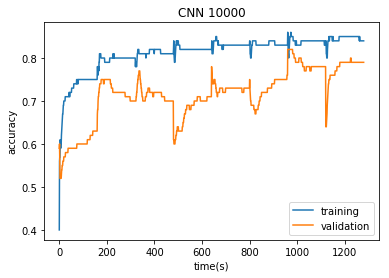

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 351us/step


  1%|          | 1/160 [00:00<01:59,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  1%|▏         | 2/160 [00:01<01:58,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  2%|▏         | 3/160 [00:02<01:57,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  2%|▎         | 4/160 [00:02<01:56,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  3%|▎         | 5/160 [00:03<01:55,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


  4%|▍         | 6/160 [00:04<01:55,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  4%|▍         | 7/160 [00:05<01:54,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  5%|▌         | 8/160 [00:05<01:53,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


  6%|▌         | 9/160 [00:06<01:52,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


  6%|▋         | 10/160 [00:07<01:52,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  7%|▋         | 11/160 [00:08<01:51,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  8%|▊         | 12/160 [00:08<01:50,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


  8%|▊         | 13/160 [00:09<01:49,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 14/160 [00:10<01:48,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


  9%|▉         | 15/160 [00:11<01:47,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 10%|█         | 16/160 [00:11<01:46,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 11%|█         | 17/160 [00:12<01:46,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 12%|█▎        | 20/160 [00:14<01:44,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 13%|█▎        | 21/160 [00:15<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 14%|█▍        | 22/160 [00:16<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 14%|█▍        | 23/160 [00:17<01:41,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 15%|█▌        | 24/160 [00:17<01:40,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 17%|█▋        | 27/160 [00:20<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 18%|█▊        | 28/160 [00:20<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 18%|█▊        | 29/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 19%|█▉        | 30/160 [00:22<01:36,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 19%|█▉        | 31/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 20%|██        | 32/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 21%|██        | 33/160 [00:24<01:34,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 22%|██▏       | 35/160 [00:26<01:32,  1.35it/s]

1999/1999 [==============================] - 1s 371us/step


 22%|██▎       | 36/160 [00:26<01:33,  1.32it/s]

1999/1999 [==============================] - 1s 350us/step


 23%|██▎       | 37/160 [00:27<01:32,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 24%|██▍       | 38/160 [00:28<01:31,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 24%|██▍       | 39/160 [00:29<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 25%|██▌       | 40/160 [00:29<01:29,  1.33it/s]

1999/1999 [==============================] - 1s 349us/step


 26%|██▌       | 41/160 [00:30<01:29,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 26%|██▋       | 42/160 [00:31<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 345us/step


 27%|██▋       | 43/160 [00:32<01:27,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 28%|██▊       | 45/160 [00:33<01:25,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 29%|██▉       | 46/160 [00:34<01:25,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 29%|██▉       | 47/160 [00:35<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 30%|███       | 48/160 [00:35<01:23,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 31%|███       | 49/160 [00:36<01:22,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 31%|███▏      | 50/160 [00:37<01:21,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 32%|███▏      | 51/160 [00:37<01:20,  1.35it/s]

1999/1999 [==============================] - 1s 361us/step


 32%|███▎      | 52/160 [00:38<01:20,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 33%|███▎      | 53/160 [00:39<01:20,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 34%|███▍      | 54/160 [00:40<01:20,  1.32it/s]

1999/1999 [==============================] - 1s 357us/step


 34%|███▍      | 55/160 [00:41<01:19,  1.32it/s]

1999/1999 [==============================] - 1s 359us/step


 35%|███▌      | 56/160 [00:41<01:19,  1.32it/s]

1999/1999 [==============================] - 1s 358us/step


 36%|███▌      | 57/160 [00:42<01:18,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 36%|███▋      | 58/160 [00:43<01:17,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 37%|███▋      | 59/160 [00:44<01:16,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 38%|███▊      | 60/160 [00:44<01:16,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 38%|███▊      | 61/160 [00:45<01:15,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 39%|███▉      | 62/160 [00:46<01:15,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 39%|███▉      | 63/160 [00:47<01:14,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 40%|████      | 64/160 [00:47<01:13,  1.31it/s]

1999/1999 [==============================] - 1s 349us/step


 41%|████      | 65/160 [00:48<01:12,  1.32it/s]

1999/1999 [==============================] - 1s 348us/step


 41%|████▏     | 66/160 [00:49<01:10,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 42%|████▎     | 68/160 [00:50<01:08,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 43%|████▎     | 69/160 [00:51<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 44%|████▍     | 70/160 [00:52<01:07,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 44%|████▍     | 71/160 [00:53<01:06,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 45%|████▌     | 72/160 [00:53<01:05,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 46%|████▌     | 73/160 [00:54<01:04,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 46%|████▋     | 74/160 [00:55<01:03,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 47%|████▋     | 75/160 [00:56<01:03,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 48%|████▊     | 76/160 [00:56<01:02,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 77/160 [00:57<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 49%|████▉     | 78/160 [00:58<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 50%|█████     | 80/160 [00:59<00:59,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 51%|█████     | 81/160 [01:00<00:58,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 51%|█████▏    | 82/160 [01:01<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 52%|█████▎    | 84/160 [01:02<00:56,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 54%|█████▍    | 86/160 [01:04<00:54,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 55%|█████▌    | 88/160 [01:05<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 56%|█████▌    | 89/160 [01:06<00:52,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 57%|█████▋    | 91/160 [01:07<00:51,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 57%|█████▊    | 92/160 [01:08<00:50,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 58%|█████▊    | 93/160 [01:09<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 345us/step


 59%|█████▉    | 94/160 [01:10<00:48,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 59%|█████▉    | 95/160 [01:10<00:48,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 60%|██████    | 96/160 [01:11<00:47,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 61%|██████    | 97/160 [01:12<00:46,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 61%|██████▏   | 98/160 [01:13<00:45,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 62%|██████▏   | 99/160 [01:13<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 62%|██████▎   | 100/160 [01:14<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 63%|██████▎   | 101/160 [01:15<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 64%|██████▍   | 103/160 [01:16<00:42,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 65%|██████▌   | 104/160 [01:17<00:41,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 66%|██████▌   | 105/160 [01:18<00:40,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 66%|██████▋   | 106/160 [01:19<00:40,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 67%|██████▋   | 107/160 [01:19<00:39,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 68%|██████▊   | 108/160 [01:20<00:38,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 68%|██████▊   | 109/160 [01:21<00:37,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 69%|██████▉   | 110/160 [01:22<00:37,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 69%|██████▉   | 111/160 [01:22<00:36,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 70%|███████   | 112/160 [01:23<00:35,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 71%|███████   | 113/160 [01:24<00:34,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 71%|███████▏  | 114/160 [01:25<00:34,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 72%|███████▏  | 115/160 [01:25<00:33,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 72%|███████▎  | 116/160 [01:26<00:32,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 73%|███████▎  | 117/160 [01:27<00:31,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 74%|███████▍  | 118/160 [01:28<00:31,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 74%|███████▍  | 119/160 [01:28<00:30,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 75%|███████▌  | 120/160 [01:29<00:29,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▌  | 121/160 [01:30<00:28,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▋  | 122/160 [01:30<00:28,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 77%|███████▋  | 123/160 [01:31<00:27,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 78%|███████▊  | 124/160 [01:32<00:26,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 78%|███████▊  | 125/160 [01:33<00:25,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 79%|███████▉  | 126/160 [01:33<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 79%|███████▉  | 127/160 [01:34<00:24,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 80%|████████  | 128/160 [01:35<00:23,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 81%|████████  | 129/160 [01:36<00:22,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 81%|████████▏ | 130/160 [01:36<00:22,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 82%|████████▏ | 131/160 [01:37<00:21,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 82%|████████▎ | 132/160 [01:38<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 83%|████████▎ | 133/160 [01:39<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 84%|████████▍ | 134/160 [01:39<00:19,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 84%|████████▍ | 135/160 [01:40<00:18,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 85%|████████▌ | 136/160 [01:41<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 86%|████████▋ | 138/160 [01:42<00:16,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 87%|████████▋ | 139/160 [01:43<00:15,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 88%|████████▊ | 140/160 [01:44<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 89%|████████▉ | 142/160 [01:45<00:13,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 89%|████████▉ | 143/160 [01:46<00:12,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 90%|█████████ | 144/160 [01:47<00:11,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.35it/s]

1999/1999 [==============================] - 1s 353us/step


 91%|█████████▏| 146/160 [01:48<00:10,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 92%|█████████▏| 147/160 [01:49<00:09,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 92%|█████████▎| 148/160 [01:50<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 94%|█████████▍| 150/160 [01:51<00:07,  1.35it/s]

1999/1999 [==============================] - 1s 357us/step


 94%|█████████▍| 151/160 [01:52<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 363us/step


 95%|█████████▌| 152/160 [01:53<00:06,  1.32it/s]

1999/1999 [==============================] - 1s 363us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.31it/s]

1999/1999 [==============================] - 1s 367us/step


 96%|█████████▋| 154/160 [01:54<00:04,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


 97%|█████████▋| 155/160 [01:55<00:03,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


 98%|█████████▊| 156/160 [01:56<00:03,  1.30it/s]

1999/1999 [==============================] - 1s 367us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.29it/s]

1999/1999 [==============================] - 1s 363us/step


 99%|█████████▉| 158/160 [01:57<00:01,  1.29it/s]

1999/1999 [==============================] - 1s 365us/step


 99%|█████████▉| 159/160 [01:58<00:00,  1.29it/s]

1999/1999 [==============================] - 1s 366us/step


100%|██████████| 160/160 [01:59<00:00,  1.29it/s]


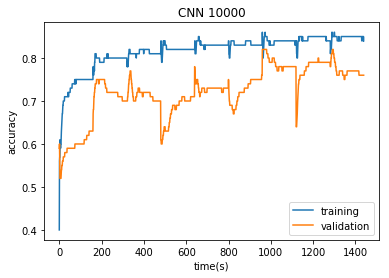

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 371us/step


  1%|          | 1/160 [00:00<02:05,  1.26it/s]

1999/1999 [==============================] - 1s 363us/step


  1%|▏         | 2/160 [00:01<02:04,  1.27it/s]

1999/1999 [==============================] - 1s 364us/step


  2%|▏         | 3/160 [00:02<02:03,  1.28it/s]

1999/1999 [==============================] - 1s 358us/step


  2%|▎         | 4/160 [00:03<02:01,  1.28it/s]

1999/1999 [==============================] - 1s 361us/step


  3%|▎         | 5/160 [00:03<02:00,  1.29it/s]

1999/1999 [==============================] - 1s 361us/step


  4%|▍         | 6/160 [00:04<01:59,  1.29it/s]

1999/1999 [==============================] - 1s 360us/step


  4%|▍         | 7/160 [00:05<01:57,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


  5%|▌         | 8/160 [00:06<01:56,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


  6%|▌         | 9/160 [00:06<01:56,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


  6%|▋         | 10/160 [00:07<01:55,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


  7%|▋         | 11/160 [00:08<01:54,  1.30it/s]

1999/1999 [==============================] - 1s 349us/step


  8%|▊         | 12/160 [00:09<01:52,  1.31it/s]

1999/1999 [==============================] - 1s 347us/step


  8%|▊         | 13/160 [00:09<01:50,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 14/160 [00:10<01:49,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 15/160 [00:11<01:48,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 10%|█         | 16/160 [00:12<01:47,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 11%|█         | 17/160 [00:12<01:46,  1.34it/s]

1999/1999 [==============================] - 1s 355us/step


 11%|█▏        | 18/160 [00:13<01:46,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 12%|█▎        | 20/160 [00:15<01:44,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 13%|█▎        | 21/160 [00:15<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 14%|█▍        | 22/160 [00:16<01:42,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 14%|█▍        | 23/160 [00:17<01:41,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 15%|█▌        | 24/160 [00:18<01:40,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 17%|█▋        | 27/160 [00:20<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 18%|█▊        | 28/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 18%|█▊        | 29/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 19%|█▉        | 30/160 [00:22<01:36,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 19%|█▉        | 31/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 20%|██        | 32/160 [00:24<01:34,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 21%|██        | 33/160 [00:24<01:34,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▏       | 35/160 [00:26<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▎       | 36/160 [00:27<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 23%|██▎       | 37/160 [00:27<01:31,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 24%|██▍       | 38/160 [00:28<01:30,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 24%|██▍       | 39/160 [00:29<01:29,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 25%|██▌       | 40/160 [00:30<01:29,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 26%|██▌       | 41/160 [00:30<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 26%|██▋       | 42/160 [00:31<01:27,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 27%|██▋       | 43/160 [00:32<01:26,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 28%|██▊       | 45/160 [00:33<01:25,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 29%|██▉       | 46/160 [00:34<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 29%|██▉       | 47/160 [00:35<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 30%|███       | 48/160 [00:35<01:23,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 31%|███       | 49/160 [00:36<01:22,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 31%|███▏      | 50/160 [00:37<01:22,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 32%|███▏      | 51/160 [00:38<01:21,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 32%|███▎      | 52/160 [00:38<01:20,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 33%|███▎      | 53/160 [00:39<01:19,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 34%|███▍      | 54/160 [00:40<01:18,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 34%|███▍      | 55/160 [00:41<01:17,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 35%|███▌      | 56/160 [00:41<01:17,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 36%|███▌      | 57/160 [00:42<01:16,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 36%|███▋      | 58/160 [00:43<01:15,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 37%|███▋      | 59/160 [00:44<01:14,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 38%|███▊      | 60/160 [00:44<01:14,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 38%|███▊      | 61/160 [00:45<01:13,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 39%|███▉      | 62/160 [00:46<01:12,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 39%|███▉      | 63/160 [00:47<01:12,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 40%|████      | 64/160 [00:47<01:11,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 41%|████      | 65/160 [00:48<01:10,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 41%|████▏     | 66/160 [00:49<01:09,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 42%|████▏     | 67/160 [00:50<01:09,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 42%|████▎     | 68/160 [00:50<01:08,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 43%|████▎     | 69/160 [00:51<01:07,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 44%|████▍     | 70/160 [00:52<01:06,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 44%|████▍     | 71/160 [00:53<01:05,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 45%|████▌     | 72/160 [00:53<01:05,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 46%|████▌     | 73/160 [00:54<01:04,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 46%|████▋     | 74/160 [00:55<01:03,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 47%|████▋     | 75/160 [00:56<01:02,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 48%|████▊     | 76/160 [00:56<01:02,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 48%|████▊     | 77/160 [00:57<01:01,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 49%|████▉     | 78/160 [00:58<01:00,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 49%|████▉     | 79/160 [00:58<01:00,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 50%|█████     | 80/160 [00:59<00:59,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 51%|█████     | 81/160 [01:00<00:58,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 51%|█████▏    | 82/160 [01:01<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 52%|█████▏    | 83/160 [01:01<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 52%|█████▎    | 84/160 [01:02<00:56,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 54%|█████▍    | 86/160 [01:04<00:55,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 54%|█████▍    | 87/160 [01:04<00:54,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 55%|█████▌    | 88/160 [01:05<00:53,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 56%|█████▌    | 89/160 [01:06<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 57%|█████▋    | 91/160 [01:07<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 57%|█████▊    | 92/160 [01:08<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 58%|█████▊    | 93/160 [01:09<00:49,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 59%|█████▉    | 94/160 [01:10<00:48,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 59%|█████▉    | 95/160 [01:10<00:48,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 60%|██████    | 96/160 [01:11<00:47,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 61%|██████    | 97/160 [01:12<00:46,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 61%|██████▏   | 98/160 [01:13<00:46,  1.35it/s]

1999/1999 [==============================] - 1s 355us/step


 62%|██████▏   | 99/160 [01:13<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 62%|██████▎   | 100/160 [01:14<00:44,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 63%|██████▎   | 101/160 [01:15<00:43,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 64%|██████▍   | 102/160 [01:16<00:43,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 64%|██████▍   | 103/160 [01:16<00:42,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 65%|██████▌   | 104/160 [01:17<00:41,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 66%|██████▌   | 105/160 [01:18<00:40,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 66%|██████▋   | 106/160 [01:19<00:40,  1.34it/s]

1999/1999 [==============================] - 1s 361us/step


 67%|██████▋   | 107/160 [01:19<00:39,  1.33it/s]

1999/1999 [==============================] - 1s 362us/step


 68%|██████▊   | 108/160 [01:20<00:39,  1.32it/s]

1999/1999 [==============================] - 1s 362us/step


 68%|██████▊   | 109/160 [01:21<00:38,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 69%|██████▉   | 110/160 [01:22<00:38,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


 69%|██████▉   | 111/160 [01:22<00:37,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 70%|███████   | 112/160 [01:23<00:36,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 71%|███████   | 113/160 [01:24<00:35,  1.31it/s]

1999/1999 [==============================] - 1s 363us/step


 71%|███████▏  | 114/160 [01:25<00:35,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 72%|███████▏  | 115/160 [01:25<00:34,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


 72%|███████▎  | 116/160 [01:26<00:33,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


 73%|███████▎  | 117/160 [01:27<00:33,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


 74%|███████▍  | 118/160 [01:28<00:32,  1.30it/s]

1999/1999 [==============================] - 1s 357us/step


 74%|███████▍  | 119/160 [01:29<00:31,  1.30it/s]

1999/1999 [==============================] - 1s 348us/step


 75%|███████▌  | 120/160 [01:29<00:30,  1.32it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 77%|███████▋  | 123/160 [01:32<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 78%|███████▊  | 124/160 [01:32<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 79%|███████▉  | 127/160 [01:35<00:24,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 80%|████████  | 128/160 [01:35<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 81%|████████  | 129/160 [01:36<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 81%|████████▏ | 130/160 [01:37<00:22,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 82%|████████▏ | 131/160 [01:37<00:21,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 82%|████████▎ | 132/160 [01:38<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 83%|████████▎ | 133/160 [01:39<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 84%|████████▍ | 134/160 [01:40<00:19,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 84%|████████▍ | 135/160 [01:40<00:18,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 85%|████████▌ | 136/160 [01:41<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 86%|████████▋ | 138/160 [01:43<00:16,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 87%|████████▋ | 139/160 [01:43<00:15,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 88%|████████▊ | 140/160 [01:44<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 89%|████████▉ | 142/160 [01:46<00:13,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 89%|████████▉ | 143/160 [01:46<00:12,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 90%|█████████ | 144/160 [01:47<00:11,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 91%|█████████▏| 146/160 [01:49<00:10,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 92%|█████████▏| 147/160 [01:49<00:09,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 92%|█████████▎| 148/160 [01:50<00:08,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 94%|█████████▍| 150/160 [01:52<00:07,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 94%|█████████▍| 151/160 [01:52<00:06,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 95%|█████████▌| 152/160 [01:53<00:05,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 96%|█████████▋| 154/160 [01:55<00:04,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 97%|█████████▋| 155/160 [01:55<00:03,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 98%|█████████▊| 156/160 [01:56<00:02,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 99%|█████████▉| 158/160 [01:58<00:01,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 99%|█████████▉| 159/160 [01:58<00:00,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


100%|██████████| 160/160 [01:59<00:00,  1.35it/s]


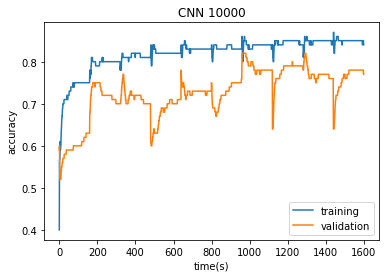

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 352us/step


  1%|          | 1/160 [00:00<01:59,  1.33it/s]

1999/1999 [==============================] - 1s 354us/step


  1%|▏         | 2/160 [00:01<01:58,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


  2%|▏         | 3/160 [00:02<01:57,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  2%|▎         | 4/160 [00:02<01:56,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  3%|▎         | 5/160 [00:03<01:55,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  4%|▍         | 6/160 [00:04<01:54,  1.34it/s]

1999/1999 [==============================] - 1s 344us/step


  4%|▍         | 7/160 [00:05<01:53,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


  5%|▌         | 8/160 [00:05<01:53,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


  6%|▌         | 9/160 [00:06<01:52,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


  6%|▋         | 10/160 [00:07<01:51,  1.34it/s]

1999/1999 [==============================] - 1s 345us/step


  7%|▋         | 11/160 [00:08<01:50,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


  8%|▊         | 12/160 [00:08<01:49,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


  8%|▊         | 13/160 [00:09<01:49,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


  9%|▉         | 14/160 [00:10<01:48,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


  9%|▉         | 15/160 [00:11<01:47,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 10%|█         | 16/160 [00:11<01:46,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 11%|█         | 17/160 [00:12<01:46,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.35it/s]

1999/1999 [==============================] - 1s 355us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 12%|█▎        | 20/160 [00:14<01:44,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 13%|█▎        | 21/160 [00:15<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 14%|█▍        | 22/160 [00:16<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 15%|█▌        | 24/160 [00:17<01:41,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 17%|█▋        | 27/160 [00:20<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 18%|█▊        | 28/160 [00:20<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 18%|█▊        | 29/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 19%|█▉        | 30/160 [00:22<01:36,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 19%|█▉        | 31/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 20%|██        | 32/160 [00:23<01:34,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 21%|██        | 33/160 [00:24<01:34,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 22%|██▏       | 35/160 [00:26<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 22%|██▎       | 36/160 [00:26<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 23%|██▎       | 37/160 [00:27<01:31,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 24%|██▍       | 38/160 [00:28<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 24%|██▍       | 39/160 [00:28<01:29,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 25%|██▌       | 40/160 [00:29<01:29,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 26%|██▌       | 41/160 [00:30<01:28,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 26%|██▋       | 42/160 [00:31<01:27,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 27%|██▋       | 43/160 [00:31<01:26,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 28%|██▊       | 45/160 [00:33<01:25,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 29%|██▉       | 46/160 [00:34<01:24,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 29%|██▉       | 47/160 [00:34<01:23,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 30%|███       | 48/160 [00:35<01:23,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 31%|███       | 49/160 [00:36<01:22,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 31%|███▏      | 50/160 [00:37<01:21,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 32%|███▏      | 51/160 [00:37<01:20,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 32%|███▎      | 52/160 [00:38<01:20,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 33%|███▎      | 53/160 [00:39<01:19,  1.35it/s]

1999/1999 [==============================] - 1s 355us/step


 34%|███▍      | 54/160 [00:40<01:19,  1.34it/s]

1999/1999 [==============================] - 1s 358us/step


 34%|███▍      | 55/160 [00:40<01:18,  1.33it/s]

1999/1999 [==============================] - 1s 359us/step


 35%|███▌      | 56/160 [00:41<01:18,  1.32it/s]

1999/1999 [==============================] - 1s 359us/step


 36%|███▌      | 57/160 [00:42<01:18,  1.32it/s]

1999/1999 [==============================] - 1s 358us/step


 36%|███▋      | 58/160 [00:43<01:17,  1.32it/s]

1999/1999 [==============================] - 1s 358us/step


 37%|███▋      | 59/160 [00:43<01:16,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 38%|███▊      | 60/160 [00:44<01:16,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 38%|███▊      | 61/160 [00:45<01:15,  1.31it/s]

1999/1999 [==============================] - 1s 363us/step


 39%|███▉      | 62/160 [00:46<01:15,  1.30it/s]

1999/1999 [==============================] - 1s 357us/step


 39%|███▉      | 63/160 [00:47<01:14,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 40%|████      | 64/160 [00:47<01:13,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 41%|████      | 65/160 [00:48<01:12,  1.31it/s]

1999/1999 [==============================] - 1s 360us/step


 41%|████▏     | 66/160 [00:49<01:11,  1.31it/s]

1999/1999 [==============================] - 1s 354us/step


 42%|████▏     | 67/160 [00:50<01:10,  1.31it/s]

1999/1999 [==============================] - 1s 362us/step


 42%|████▎     | 68/160 [00:50<01:10,  1.31it/s]

1999/1999 [==============================] - 1s 359us/step


 43%|████▎     | 69/160 [00:51<01:09,  1.31it/s]

1999/1999 [==============================] - 1s 365us/step


 44%|████▍     | 70/160 [00:52<01:09,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


 44%|████▍     | 71/160 [00:53<01:08,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


 45%|████▌     | 72/160 [00:53<01:07,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


 46%|████▌     | 73/160 [00:54<01:06,  1.30it/s]

1999/1999 [==============================] - 1s 353us/step


 46%|████▋     | 74/160 [00:55<01:05,  1.31it/s]

1999/1999 [==============================] - 1s 348us/step


 47%|████▋     | 75/160 [00:56<01:04,  1.32it/s]

1999/1999 [==============================] - 1s 348us/step


 48%|████▊     | 76/160 [00:56<01:03,  1.33it/s]

1999/1999 [==============================] - 1s 350us/step


 48%|████▊     | 77/160 [00:57<01:02,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 49%|████▉     | 78/160 [00:58<01:01,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 49%|████▉     | 79/160 [00:59<01:00,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 50%|█████     | 80/160 [00:59<00:59,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 51%|█████     | 81/160 [01:00<00:58,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 51%|█████▏    | 82/160 [01:01<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 52%|█████▏    | 83/160 [01:02<00:57,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 52%|█████▎    | 84/160 [01:02<00:56,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 53%|█████▎    | 85/160 [01:03<00:55,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 54%|█████▍    | 86/160 [01:04<00:54,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 54%|█████▍    | 87/160 [01:05<00:54,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 55%|█████▌    | 88/160 [01:05<00:53,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 56%|█████▌    | 89/160 [01:06<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 56%|█████▋    | 90/160 [01:07<00:52,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 57%|█████▋    | 91/160 [01:08<00:51,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 57%|█████▊    | 92/160 [01:08<00:50,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 58%|█████▊    | 93/160 [01:09<00:49,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 59%|█████▉    | 94/160 [01:10<00:48,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 59%|█████▉    | 95/160 [01:11<00:48,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 60%|██████    | 96/160 [01:11<00:47,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 61%|██████    | 97/160 [01:12<00:46,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 61%|██████▏   | 98/160 [01:13<00:45,  1.35it/s]

1999/1999 [==============================] - 1s 356us/step


 62%|██████▏   | 99/160 [01:14<00:45,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 62%|██████▎   | 100/160 [01:14<00:44,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 63%|██████▎   | 101/160 [01:15<00:43,  1.35it/s]

1999/1999 [==============================] - 1s 344us/step


 64%|██████▍   | 102/160 [01:16<00:42,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 64%|██████▍   | 103/160 [01:16<00:42,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 65%|██████▌   | 104/160 [01:17<00:41,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 66%|██████▌   | 105/160 [01:18<00:40,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 66%|██████▋   | 106/160 [01:19<00:40,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 67%|██████▋   | 107/160 [01:19<00:39,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 68%|██████▊   | 108/160 [01:20<00:38,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 68%|██████▊   | 109/160 [01:21<00:37,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 69%|██████▉   | 110/160 [01:22<00:36,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 69%|██████▉   | 111/160 [01:22<00:36,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 70%|███████   | 112/160 [01:23<00:35,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 71%|███████   | 113/160 [01:24<00:34,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 71%|███████▏  | 114/160 [01:25<00:34,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 72%|███████▏  | 115/160 [01:25<00:33,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 72%|███████▎  | 116/160 [01:26<00:32,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 73%|███████▎  | 117/160 [01:27<00:31,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 74%|███████▍  | 118/160 [01:28<00:31,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 74%|███████▍  | 119/160 [01:28<00:30,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 75%|███████▌  | 120/160 [01:29<00:29,  1.34it/s]

1999/1999 [==============================] - 1s 359us/step


 76%|███████▌  | 121/160 [01:30<00:29,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 76%|███████▋  | 122/160 [01:31<00:28,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 77%|███████▋  | 123/160 [01:31<00:27,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 78%|███████▊  | 124/160 [01:32<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 78%|███████▊  | 125/160 [01:33<00:26,  1.34it/s]

1999/1999 [==============================] - 1s 353us/step


 79%|███████▉  | 126/160 [01:34<00:25,  1.33it/s]

1999/1999 [==============================] - 1s 348us/step


 79%|███████▉  | 127/160 [01:34<00:24,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 80%|████████  | 128/160 [01:35<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 81%|████████  | 129/160 [01:36<00:23,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 81%|████████▏ | 130/160 [01:37<00:22,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 82%|████████▏ | 131/160 [01:37<00:21,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 82%|████████▎ | 132/160 [01:38<00:20,  1.34it/s]

1999/1999 [==============================] - 1s 345us/step


 83%|████████▎ | 133/160 [01:39<00:20,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 84%|████████▍ | 134/160 [01:40<00:19,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 84%|████████▍ | 135/160 [01:40<00:18,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 85%|████████▌ | 136/160 [01:41<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 86%|████████▌ | 137/160 [01:42<00:17,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 86%|████████▋ | 138/160 [01:42<00:16,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 87%|████████▋ | 139/160 [01:43<00:15,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 88%|████████▊ | 140/160 [01:44<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 345us/step


 88%|████████▊ | 141/160 [01:45<00:14,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 89%|████████▉ | 142/160 [01:45<00:13,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 89%|████████▉ | 143/160 [01:46<00:12,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 90%|█████████ | 144/160 [01:47<00:11,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 91%|█████████ | 145/160 [01:48<00:11,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 91%|█████████▏| 146/160 [01:48<00:10,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 92%|█████████▏| 147/160 [01:49<00:09,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 92%|█████████▎| 148/160 [01:50<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 93%|█████████▎| 149/160 [01:51<00:08,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 94%|█████████▍| 150/160 [01:51<00:07,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 94%|█████████▍| 151/160 [01:52<00:06,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 95%|█████████▌| 152/160 [01:53<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 96%|█████████▌| 153/160 [01:54<00:05,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 96%|█████████▋| 154/160 [01:54<00:04,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 97%|█████████▋| 155/160 [01:55<00:03,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 98%|█████████▊| 156/160 [01:56<00:02,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 98%|█████████▊| 157/160 [01:57<00:02,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 99%|█████████▉| 158/160 [01:57<00:01,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 99%|█████████▉| 159/160 [01:58<00:00,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


100%|██████████| 160/160 [01:59<00:00,  1.35it/s]


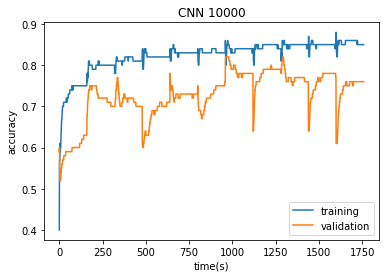

  0%|          | 0/160 [00:00<?, ?it/s]

1999/1999 [==============================] - 1s 363us/step


  1%|          | 1/160 [00:00<02:03,  1.29it/s]

1999/1999 [==============================] - 1s 359us/step


  1%|▏         | 2/160 [00:01<02:02,  1.29it/s]

1999/1999 [==============================] - 1s 357us/step


  2%|▏         | 3/160 [00:02<02:00,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


  2%|▎         | 4/160 [00:03<01:59,  1.30it/s]

1999/1999 [==============================] - 1s 362us/step


  3%|▎         | 5/160 [00:03<01:59,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


  4%|▍         | 6/160 [00:04<01:58,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


  4%|▍         | 7/160 [00:05<01:57,  1.30it/s]

1999/1999 [==============================] - 1s 363us/step


  5%|▌         | 8/160 [00:06<01:56,  1.30it/s]

1999/1999 [==============================] - 1s 359us/step


  6%|▌         | 9/160 [00:06<01:55,  1.30it/s]

1999/1999 [==============================] - 1s 361us/step


  6%|▋         | 10/160 [00:07<01:55,  1.30it/s]

1999/1999 [==============================] - 1s 360us/step


  7%|▋         | 11/160 [00:08<01:54,  1.30it/s]

1999/1999 [==============================] - 1s 358us/step


  8%|▊         | 12/160 [00:09<01:53,  1.31it/s]

1999/1999 [==============================] - 1s 358us/step


  8%|▊         | 13/160 [00:09<01:52,  1.31it/s]

1999/1999 [==============================] - 1s 347us/step


  9%|▉         | 14/160 [00:10<01:50,  1.32it/s]

1999/1999 [==============================] - 1s 345us/step


  9%|▉         | 15/160 [00:11<01:48,  1.33it/s]

1999/1999 [==============================] - 1s 347us/step


 10%|█         | 16/160 [00:12<01:47,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 11%|█         | 17/160 [00:12<01:46,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 11%|█▏        | 18/160 [00:13<01:45,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 12%|█▏        | 19/160 [00:14<01:45,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 12%|█▎        | 20/160 [00:15<01:44,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 13%|█▎        | 21/160 [00:15<01:43,  1.34it/s]

1999/1999 [==============================] - 1s 347us/step


 14%|█▍        | 22/160 [00:16<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 350us/step


 14%|█▍        | 23/160 [00:17<01:42,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 15%|█▌        | 24/160 [00:18<01:41,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 16%|█▌        | 25/160 [00:18<01:40,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 16%|█▋        | 26/160 [00:19<01:39,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 17%|█▋        | 27/160 [00:20<01:38,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 18%|█▊        | 28/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 18%|█▊        | 29/160 [00:21<01:37,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 19%|█▉        | 30/160 [00:22<01:36,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 19%|█▉        | 31/160 [00:23<01:35,  1.35it/s]

1999/1999 [==============================] - 1s 352us/step


 20%|██        | 32/160 [00:24<01:35,  1.34it/s]

1999/1999 [==============================] - 1s 349us/step


 21%|██        | 33/160 [00:24<01:34,  1.34it/s]

1999/1999 [==============================] - 1s 346us/step


 21%|██▏       | 34/160 [00:25<01:33,  1.35it/s]

1999/1999 [==============================] - 1s 346us/step


 22%|██▏       | 35/160 [00:26<01:32,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 22%|██▎       | 36/160 [00:27<01:32,  1.34it/s]

1999/1999 [==============================] - 1s 351us/step


 23%|██▎       | 37/160 [00:27<01:31,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 24%|██▍       | 38/160 [00:28<01:30,  1.34it/s]

1999/1999 [==============================] - 1s 348us/step


 24%|██▍       | 39/160 [00:29<01:29,  1.35it/s]

1999/1999 [==============================] - 1s 349us/step


 25%|██▌       | 40/160 [00:30<01:29,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 26%|██▌       | 41/160 [00:30<01:28,  1.35it/s]

1999/1999 [==============================] - 1s 348us/step


 26%|██▋       | 42/160 [00:31<01:27,  1.35it/s]

1999/1999 [==============================] - 1s 347us/step


 27%|██▋       | 43/160 [00:32<01:26,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 28%|██▊       | 44/160 [00:32<01:26,  1.35it/s]

1999/1999 [==============================] - 1s 350us/step


 28%|██▊       | 45/160 [00:33<01:25,  1.35it/s]

1999/1999 [==============================] - 1s 351us/step


 29%|██▉       | 46/160 [00:34<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 352us/step


 29%|██▉       | 47/160 [00:35<01:24,  1.34it/s]

1999/1999 [==============================] - 1s 354us/step


 30%|███       | 48/160 [00:35<01:23,  1.34it/s]

  32/1999 [..............................] - ETA: 0s

KeyboardInterrupt: 

In [26]:
#normally you would want to reshuffle the data between epochs, we don't as we split in-place into training/validation
epochs = 200 #how many epochs we want to perform（代表每一张图片上训练三次）
time=0
accurate1=[]
accurate2=[]
x_validation=X[split_idx:X.shape[0]-1]
y_validation=y[split_idx:y.shape[0]-1]
for epoch in range(epochs):
    #compute how many batches we'll need
    iterations = np.floor(split_idx / batch_size).astype(int) #the floor makes us discard a few samples here, I got lazy...
    loss1,loss2,acc1,acc2 = 0,0,0,0 #we will compute running loss and accuracy
    with trange(iterations) as t: #display a progress bar
        for i in t:
            start_idx = i * batch_size #starting index of the current batch
            x_batch = X[start_idx:start_idx+batch_size] #the current batch
            y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

            metrics1 = model.train_on_batch(x_batch, y_batch) #train the model on a batch
            
            metrics2 = model.evaluate(x_validation,y_validation)
            
            loss1 = loss1 + metrics1[0] #compute running loss
            acc1 = acc1 + metrics1[1] #compute running accuracy
            accurate1.append(round(acc1 / (i+1),2))
            
            
            loss2 = loss2 + metrics2[0] #compute running loss
            acc2 = acc2 + metrics2[1] #compute running accuracy
            accurate2.append(round(acc2 / (i+1),2))
            time = time+1
            #t.set_description('Running training epoch ' + str(epoch)) #set progressbar title
            #t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) #display metrics
            
    printplot(time,accurate1,accurate2)

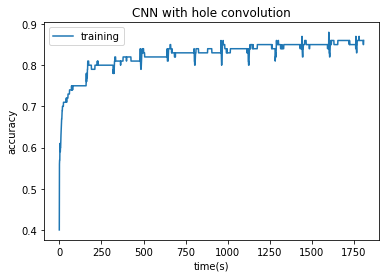

In [27]:

i=os.system("cls")
plt.plot(range(time), accurate1, mec='r', mfc='w',label=u'training')
plt.legend()  # 让图例生效
plt.xlabel("time(s)") #X轴标签
plt.ylabel("accuracy") #Y轴标签
plt.title("CNN with hole convolution") #标题

plt.show()

Create a submission

In [ ]:
'''
X = None
y = None
gc.collect();
'''

In [ ]:
'''
base_test_dir = path + 'test/' #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines
'''

In [ ]:
#submission.to_csv("submission.csv", index = False, header = True) #create the submission file